## Figure generation

In [1]:
!pip install torch tensorflow_ranking tensorflow_probability numba fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 65.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 39.4 MB/s eta 0:00:0000:0100:01
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp39-cp39-linux_x86_64.whl size=534698 sha256=93da94368fb52e76c5094392cc4938995a67fc1b1e978638def0d945f4f5f208
  Stored in directory: /root/.cache/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1
from keras.optimizers import Adam

import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import torch

import random
from scipy.stats import multivariate_normal

import pickle

from VAE import Sampling, VAE, get_auth_model_from_latent_space, get_decoder, get_encoder
from WAE import WAE, get_decoder as get_decoder_wae, get_encoder as get_encoder_wae
from VAE_torch import VAE as VAE_torch, Encoder, Decoder
from scaler import CustomScaler


2023-04-25 08:38:40.552824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 08:38:41.698892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 08:38:41.698997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-25 08:38:41.699008: W tensorfl

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
print(device_name)

file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy")[:,:,[0,1,2,4,5,6]]
print(x_data.shape)

#from featurize import filter as _filter, ORDER, CUTOFF, FILTER_INDICES
#x_data = _filter(x_data, FILTER_INDICES, ORDER, CUTOFF)

y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy").astype(int)
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy").astype(int)
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy").astype(int)

_map = (train_gesture_map == 1) #& ((y_user.argmax(axis=1) >= 14))
user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]


/device:GPU:0
(34255, 200, 6)


## Load models for many different types of model

In [3]:
def general_load(folder, model_name):

    if "TORCH" in model_name:
        vae = VAE_torch(latent_dim=10)
    elif "wae" in model_name:
        vae = WAE(None, None, None, None, scale_included=True)
    else:
        vae = VAE(None, None, None, None, scale_included=True, loss_func="MSE")
    vae.load_model(f"{folder}", f"{model_name}")
    return vae

In [4]:
def dimension_reduction(z_pca, labels) -> pd.DataFrame:

    visualisation = TSNE(n_components=2).fit_transform(z_pca)
    df = pd.DataFrame(visualisation, columns = ["dimension 1", "dimension 2"])  #, "dimension 3"
    df["labels"] = labels
    return df


def visualise_TSNE(data, labels):
    df = dimension_reduction(data, labels)

    fig, ax = plt.subplots(1,1, figsize=(24,12) ) # , subplot_kw={"projection": "3d"})# , 
                           
    ax.scatter(df["dimension 1"], df["dimension 2"],  c = df["labels"], cmap = "rainbow") #  df["dimension 3"],
    ax.set_xlabel("z[{i}]")
    ax.set_ylabel("z[{j}]")
    #plt.colorbar()
    
    plt.show()

## Showing gesture data

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv1d(input, weight, bias, self.stride,
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:950: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


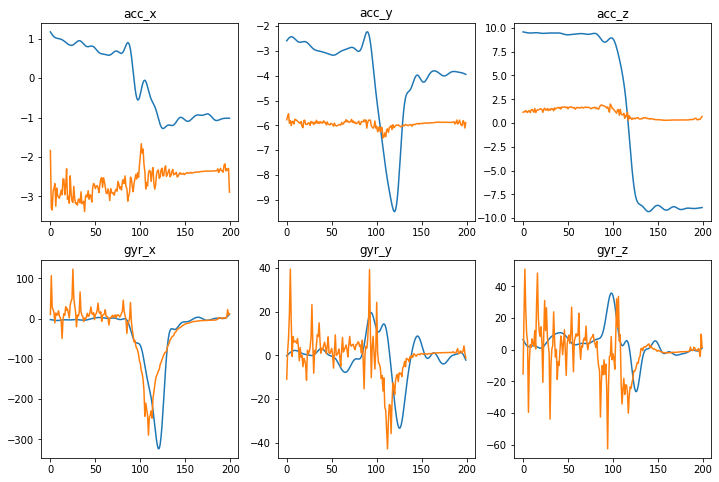

In [5]:
CHANNEL_NAMES = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]

def show_one_gesture(gesture):
    fig,ax = plt.subplots(2,3, figsize=(12,8))
    for channel in range(6):
        ax[divmod(channel,3)].plot(gesture[:,channel])
    return plt

def show_one_gesture_against_reconstruction(gesture, reconstruction):
    fig,ax = plt.subplots(2,3, figsize=(12,8))
    
    for channel in range(6):
        ax[divmod(channel,3)].plot(gesture[:,channel])
        ax[divmod(channel,3)].plot(reconstruction[:,channel])
        ax[divmod(channel,3)].set_title(CHANNEL_NAMES[channel])
    return plt

def show_multiple_gestures(gestures, reconstructions, channel=0):
    fig,ax = plt.subplots(1,5, figsize=(12,8))
    
    for i in range(5):
        ax[i].plot(gestures[i,:,channel])
        ax[i].plot(reconstructions[i,:,channel])
        ax[i].set_title(f"Gesture # {i} - {CHANNEL_NAMES[channel]} ")
    return plt

model_names = ["naive_autoencoder_TORCH_softdtw_10", "naive_autoencoder_lbkeogh_mod_stats_10", "naive_autoencoder_mse_10","naive_autoencoder_lbkeogh_mod_10",  #  "naive_autoencoder_lbkeogh_10",
              "naive_autoencoder_mse_stats_10"]

model_name = model_names[0]
vae = general_load("Gen", model_name)

## Train gesture #1, gyr_z gives a favourable comparison of loss functions methods

ix = 0
datapoint = x_data[train_gesture_map == 1][ix:ix+2]

if "TORCH" in model_name:
    _in = vae.scaler.transform(datapoint)
    _in = np.swapaxes(_in, 1,2)
    enc, _, _ = vae.encoder(torch.Tensor(_in).to("cuda"))
    dec = vae.decoder(enc).detach().cpu().numpy() 
    dec = vae.scaler.inverse_transform(np.swapaxes(dec, 1,2))
elif "wae" in model_name:
    enc = vae.encoder(vae.scaler.transform(datapoint))
    dec = vae.scaler.inverse_transform(vae.decoder(enc).numpy())
else:
    enc = vae.encoder(vae.scaler.transform(datapoint))[0]
    dec = vae.scaler.inverse_transform(vae.decoder(enc).cpu().numpy())


#plt = show_one_gesture(datapoint[0])
#plt.show()
plt = show_one_gesture_against_reconstruction(datapoint[0], dec[0])
plt.show()

## Showing PCA of feature space

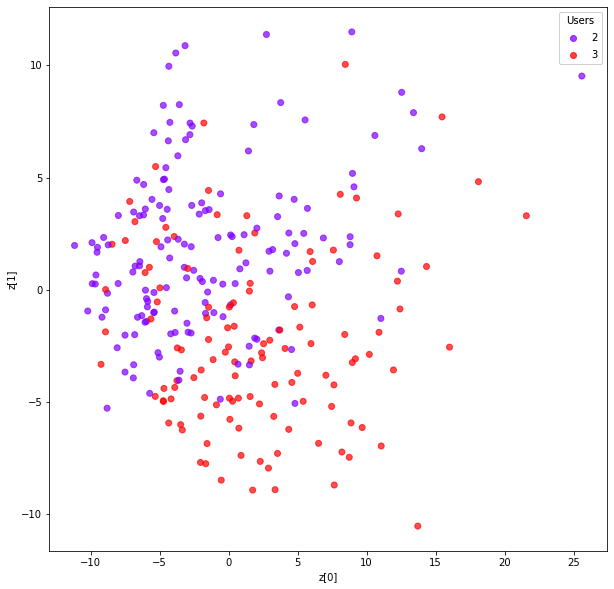

In [6]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def plot_pca12(data, labels):
    
    data,labels = unison_shuffled_copies(data, labels)
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.7, cmap = "rainbow")
    ax.set_xlabel(f"z[{0}]")
    ax.set_ylabel(f"z[{1}]")
    legend = ax.legend(*scatter.legend_elements(),
                loc="upper right", title="Users")
    ax.add_artist(legend)
    #plt.colorbar()
    plt.show()

def plot_label_clusters(data, labels, comps=5):
    # display a 2D plot of the user classes in the latent space

    pair_set = [(i,j) for i in range(comps) for j in range(i+1,comps)]
    
    fig, ax = plt.subplots(1 + len(pair_set)//3,3, figsize=(24,48))
    
    for ix, (i,j) in enumerate(pair_set):
        scatter = ax[divmod(ix, 3)].scatter(data[:, i], data[:, j], c=labels, alpha=0.1, cmap = "rainbow")
        ax[divmod(ix, 3)].set_xlabel(f"z[{i}]")
        ax[divmod(ix, 3)].set_ylabel(f"z[{j}]")
        legend = ax[divmod(ix, 3)].legend(*scatter.legend_elements(),
                    loc="upper right", title="Users")
        ax[divmod(ix, 3)].add_artist(legend)
    #plt.colorbar()
    plt.show()

x_features = np.load(f"data/processed/x_raw_with_maps_features.npy")

ss = StandardScaler()
user_restriction =  (train_gesture_map==1) & (y_user.argmax(axis=1) <=3) & (y_user.argmax(axis=1) >=2)
x_features = ss.fit_transform(x_features[user_restriction])
pca = PCA()
x_pca = pca.fit_transform(x_features)


plot_pca12(x_pca, y_user.argmax(axis=1)[user_restriction])


## Showing PCA of latent space

In [6]:
model_name = model_names[0]
vae = general_load("Gen", "naive_autoencoder_lbkeogh_mod_stats_10")


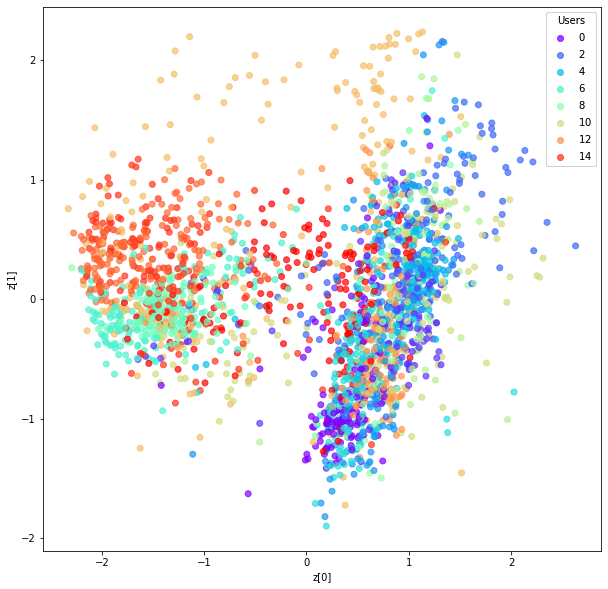

In [7]:


_map = (train_gesture_map == 1) #& (y_user.argmax(axis=1) >= 14)
data = x_data[_map]
enc = vae.encoder(vae.scaler.transform(data))[0]

pca = PCA()
plot_x = pca.fit_transform(enc)


plot_pca12(plot_x, y_user.argmax(axis=1)[_map]) # do a version without user colouring?

## VAEs of varying sizes

In [8]:
vaes = []
vae_histories = []
for beta in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    print(beta)
    name = f"vae_lbkeogh_mod_stats_beta={beta}_10"
    vae = general_load("Gen",name)
    
    vaes.append(vae)
    
    
    with open(f"data/losses/Gen/{name}.pickle", "rb") as file:
        vae_histories.append(pickle.load(file))


1
0.1
0.01
0.001
0.0001
1e-05
1e-06


1
[[0.9999982  1.0000035  1.0000033  ... 1.000006   0.9999988  0.9999991 ]
 [0.99999756 1.000003   1.0000029  ... 1.0000052  0.9999983  0.9999987 ]
 [0.999998   1.0000033  1.0000031  ... 1.0000061  0.9999988  0.9999988 ]
 ...
 [0.9999975  1.0000031  1.0000031  ... 1.0000056  0.9999983  0.9999991 ]
 [0.99999785 1.0000035  1.0000035  ... 1.0000058  0.99999875 0.9999996 ]
 [0.9999978  1.0000033  1.0000032  ... 1.0000057  0.9999984  0.99999917]]


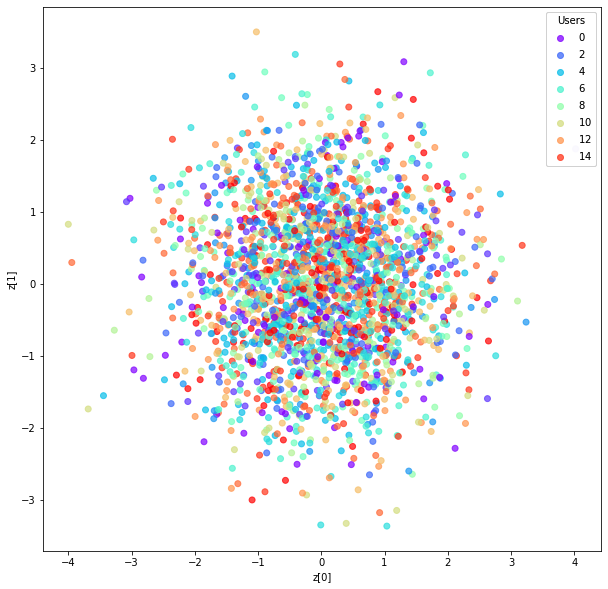

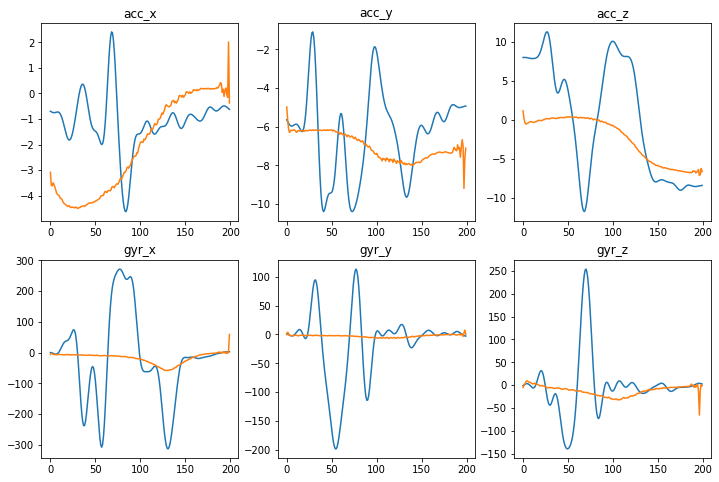

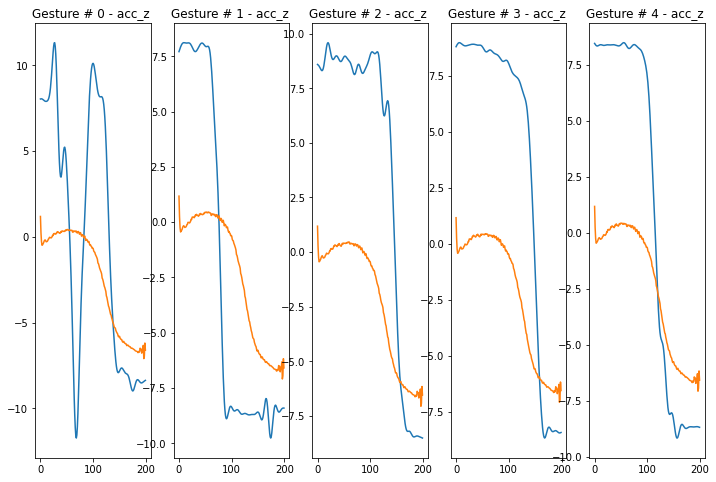

0.1
[[1.0000161  0.99999225 0.9999992  ... 0.9999975  1.000048   0.99999446]
 [1.0000046  0.9999816  0.99998313 ... 0.99997354 1.0000355  0.9999861 ]
 [1.0000286  1.0000081  1.0000252  ... 1.0000272  1.0000639  1.0000068 ]
 ...
 [1.000025   0.99999404 0.9999925  ... 1.0000073  1.0000521  1.0000073 ]
 [1.0000237  0.99999255 0.99998826 ... 1.0000025  1.00005    1.0000064 ]
 [1.0000246  0.999994   0.99999267 ... 1.0000045  1.0000511  1.0000068 ]]


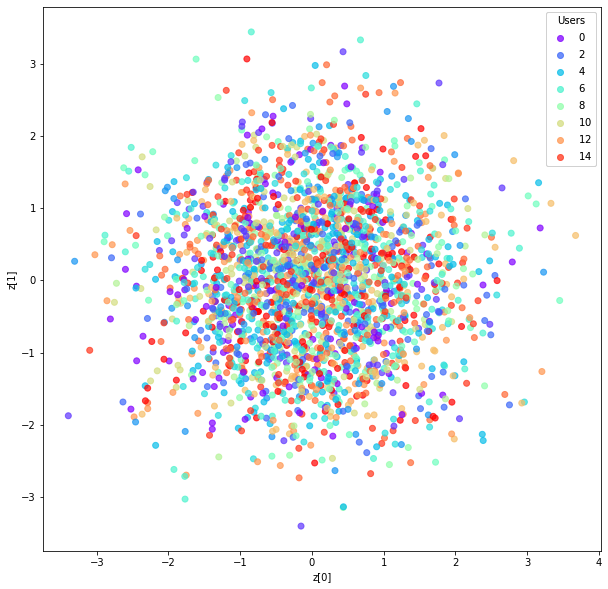

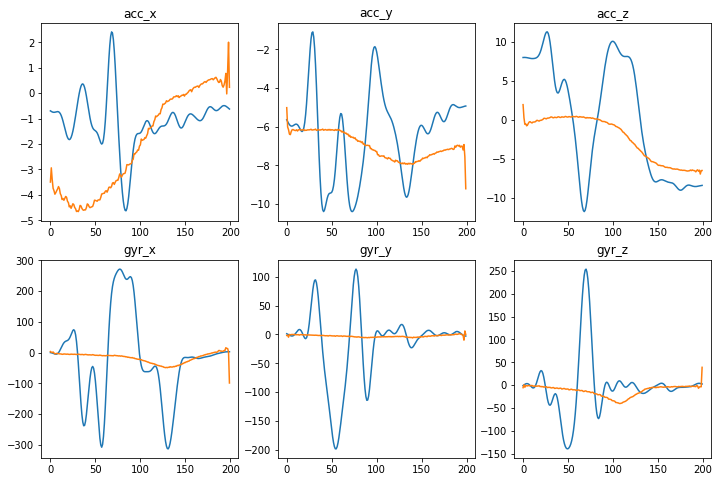

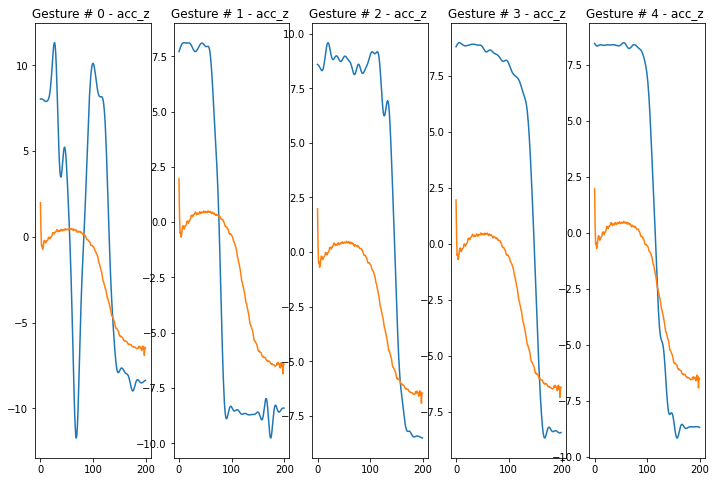

0.01
[[0.9996279  0.9994364  0.99932784 ... 0.9994524  0.9995161  0.9993107 ]
 [0.99946195 0.99920833 0.99904406 ... 0.99923146 0.99933934 0.9990074 ]
 [0.9999156  0.9998618  0.99986047 ... 0.99986887 0.99983495 0.9998653 ]
 ...
 [1.0000007  1.000029   1.000034   ... 0.9999829  0.9999499  1.0000728 ]
 [0.99996275 0.99996126 0.9999513  ... 0.9999204  0.999899   0.99997693]
 [0.99996257 0.99995446 0.999946   ... 0.9999096  0.9998971  0.9999705 ]]


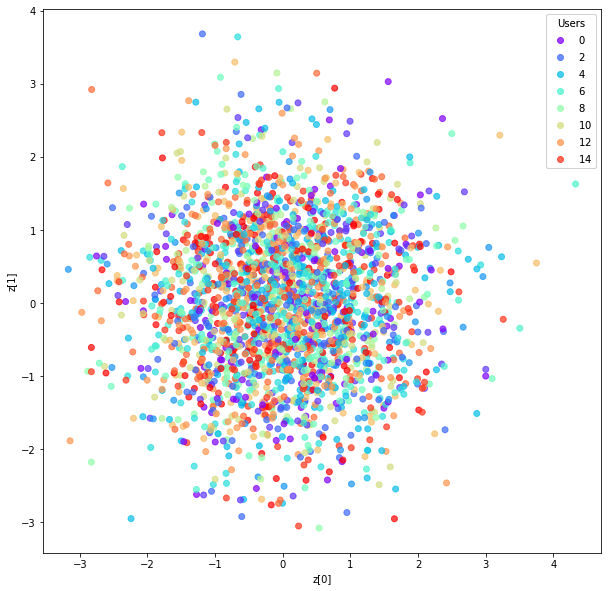

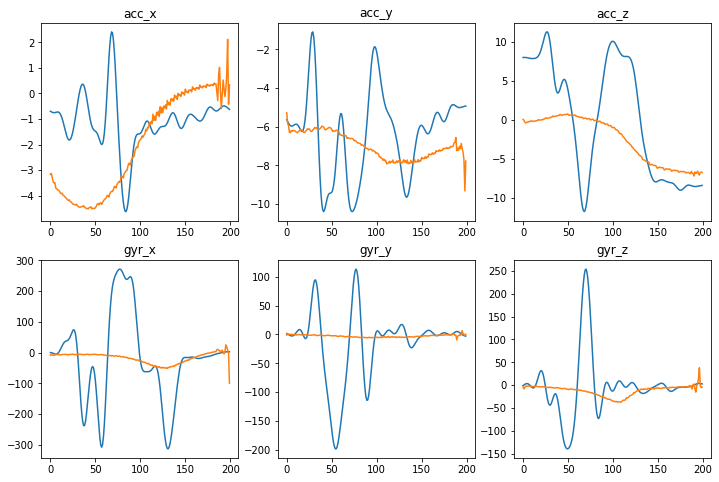

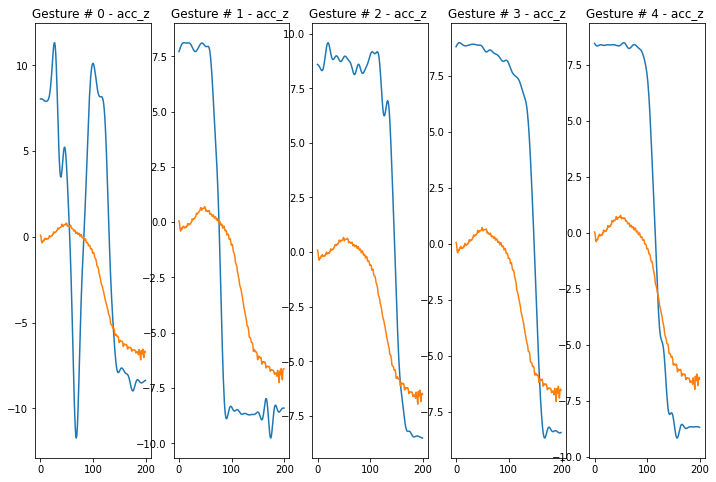

0.001
[[0.9871386  0.98424876 0.98528385 ... 0.98635316 0.98682827 0.4942521 ]
 [0.9892559  0.98637724 0.9876466  ... 0.9884656  0.9885655  0.3955032 ]
 [0.9898713  0.99153304 0.9889009  ... 0.99009806 0.9903074  0.6618354 ]
 ...
 [1.0038548  1.0020167  1.0015272  ... 1.0020399  1.0017715  0.30904546]
 [1.0085267  1.0060413  1.0047174  ... 1.005921   1.005726   0.24766514]
 [1.0058995  1.003776   1.0031785  ... 1.0038098  1.0035977  0.27191836]]


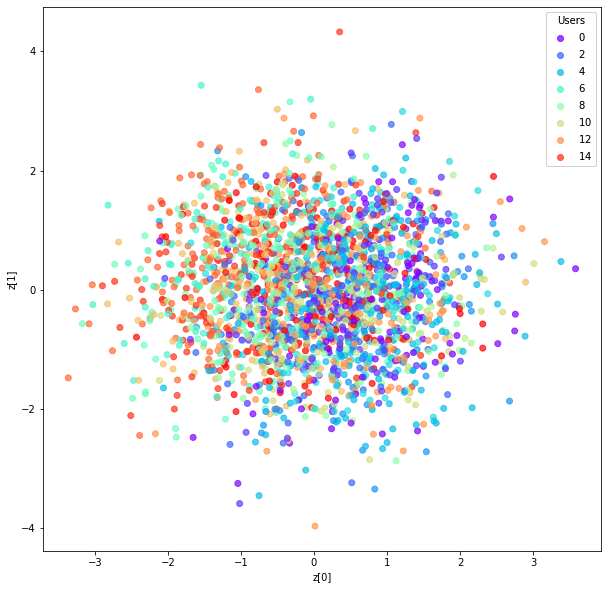

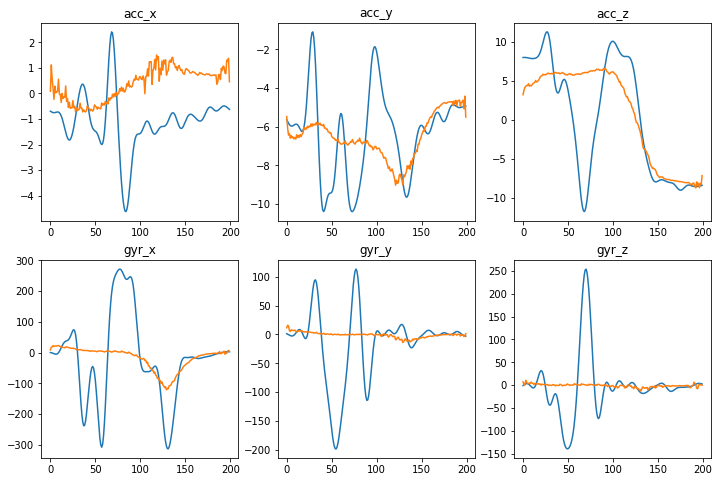

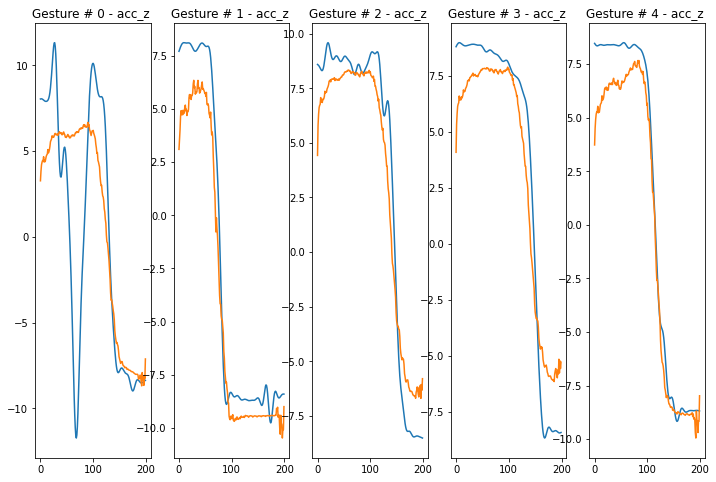

0.0001
[[0.98890823 0.98351234 0.09533387 ... 0.05150891 0.9813659  0.9805118 ]
 [0.98581135 0.98219615 0.08637804 ... 0.04591596 0.9805315  0.98037285]
 [0.9766472  0.97386825 0.09967598 ... 0.06313572 0.9721447  0.9678488 ]
 ...
 [0.977022   0.9837442  0.08687421 ... 0.0802619  0.9783112  0.9770899 ]
 [0.9708614  0.9755267  0.08649361 ... 0.10597553 0.969904   0.965534  ]
 [0.9757485  0.9845701  0.07826146 ... 0.07173625 0.98048353 0.9788138 ]]


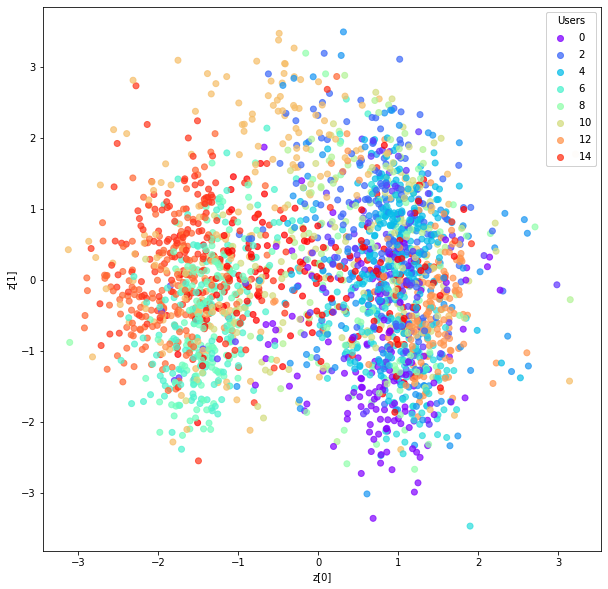

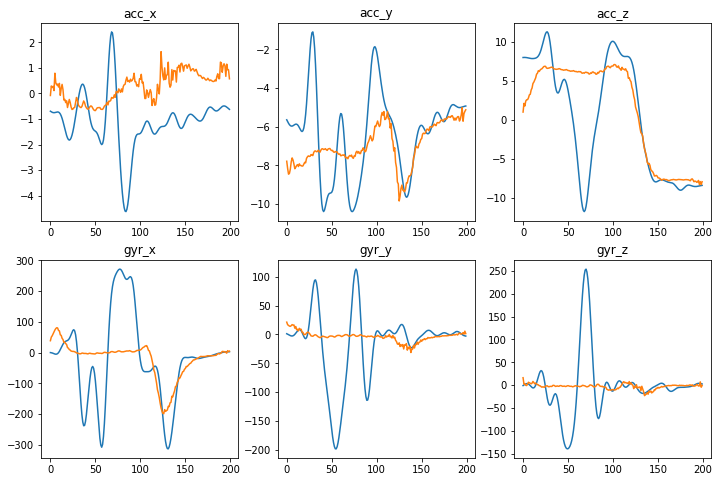

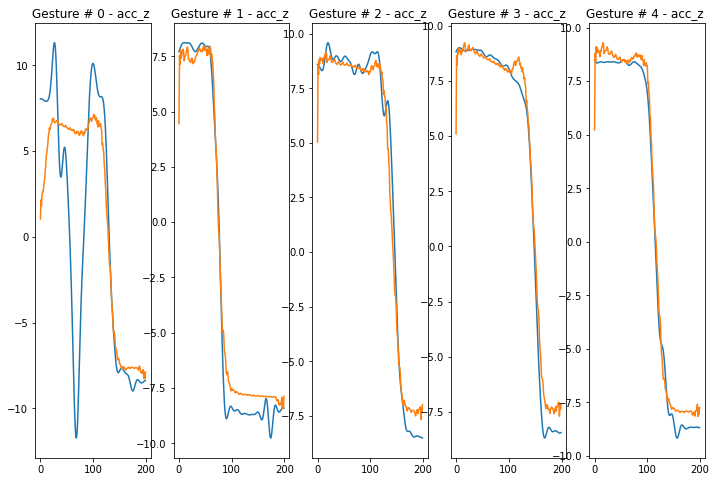

1e-05
[[0.01230266 0.01466277 0.01773534 ... 0.7501222  0.85463774 0.7988558 ]
 [0.01152166 0.01401617 0.01669306 ... 0.74259657 0.84690505 0.78153867]
 [0.01972    0.02184869 0.02696127 ... 0.7794785  0.877679   0.8485101 ]
 ...
 [0.01583033 0.01660736 0.01866323 ... 0.7498774  0.8635485  0.7975224 ]
 [0.02481702 0.02476118 0.02622169 ... 0.7542566  0.8684059  0.7955652 ]
 [0.01451543 0.01523315 0.01694426 ... 0.7426797  0.86134815 0.7914742 ]]


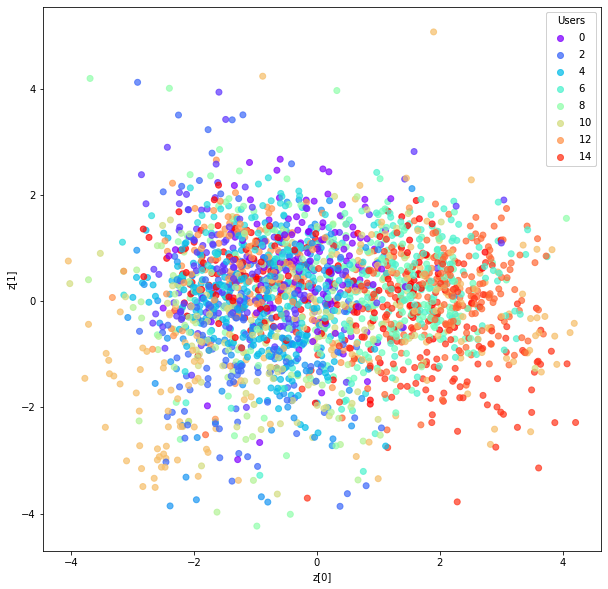

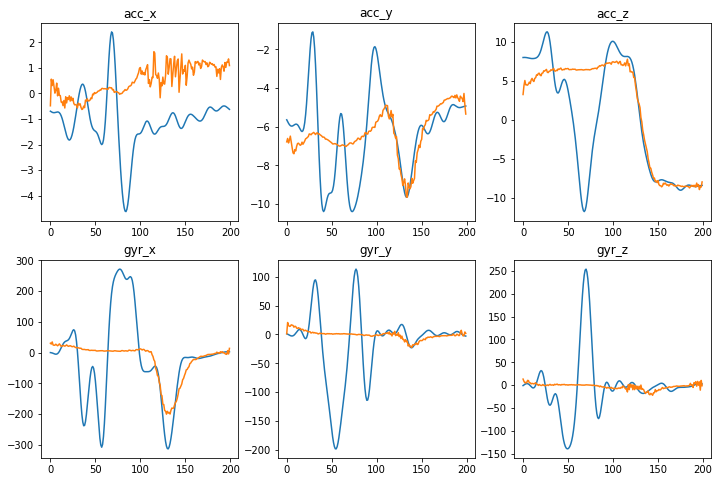

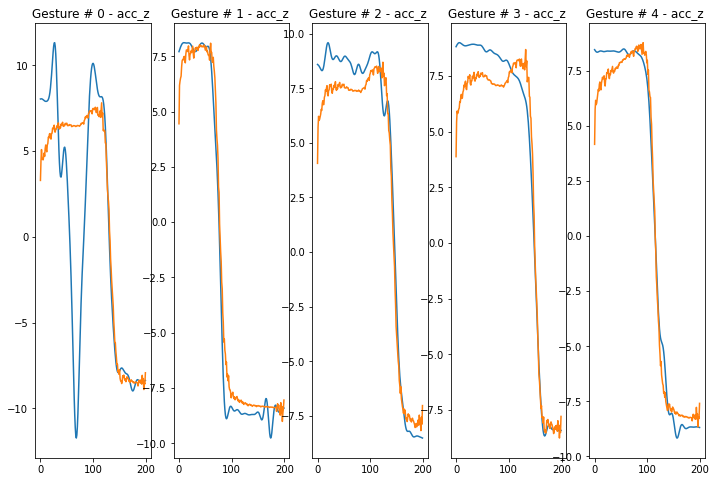

1e-06
[[0.08044269 0.04149029 0.01797819 ... 0.01671679 0.09173307 0.02827721]
 [0.0701978  0.03179308 0.01412161 ... 0.01275909 0.08195092 0.02222738]
 [0.08283254 0.05504511 0.02087109 ... 0.02177242 0.09301038 0.03574544]
 ...
 [0.04836902 0.00910806 0.00708937 ... 0.00627727 0.06958856 0.01002459]
 [0.07613926 0.01200498 0.01468412 ... 0.01258531 0.10583452 0.01589489]
 [0.04587028 0.00785809 0.00630681 ... 0.00544389 0.06611826 0.00875284]]


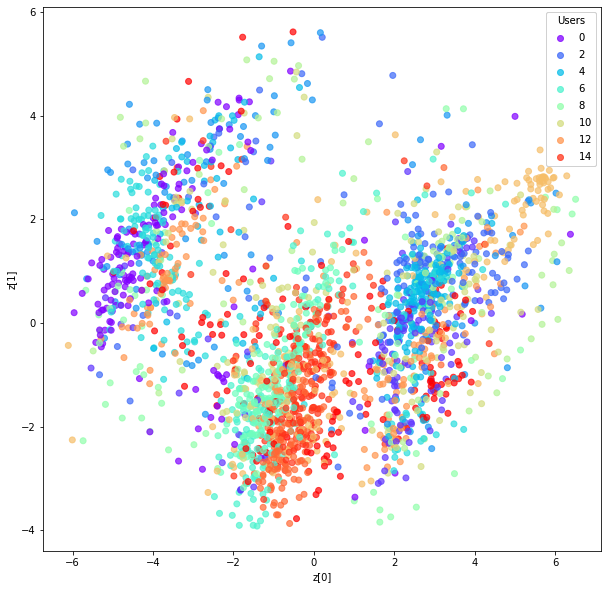

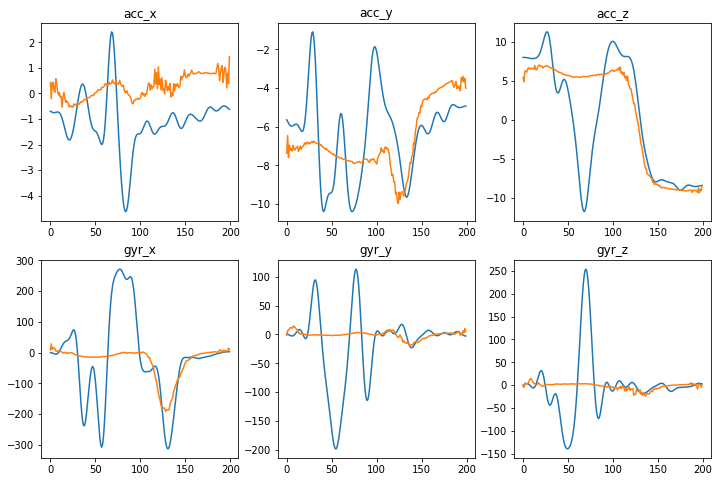

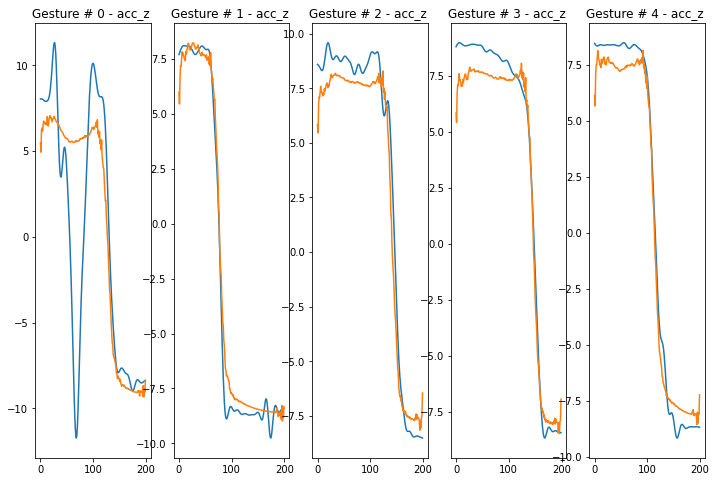

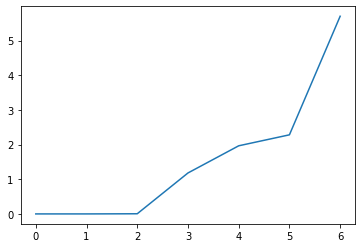

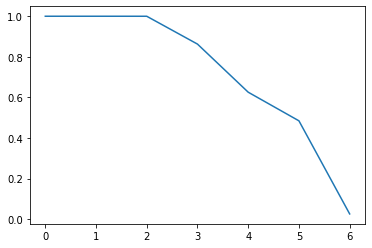

[7.6279492e-04 8.6714886e-04 5.2744835e-03 1.1819658e+00 1.9654690e+00
 2.2819638e+00 5.7020922e+00]
[1.0000012, 1.0000055, 0.99992037, 0.86276764, 0.6256933, 0.48466012, 0.025908949]


In [9]:
av_means = []
av_stds = []
for i, vae in enumerate(vaes):
    print(10**-i)
    _map = (train_gesture_map == 1) #& (y_user.argmax(axis=1) >= 13)
    data = x_data[_map]
    z_mean, z_log_var, z = vae.encoder(vae.scaler.transform(data))
    av_means.append( np.mean(np.linalg.norm(z_mean, axis=1))) 
    av_stds.append( np.mean(abs(np.exp(0.5 * z_log_var)))) 
    
    enc = np.array(z)
    print(np.exp(0.5 * z_log_var))
    pca = PCA()
    plot_x = pca.fit_transform(enc)

    plot_pca12(plot_x, y_user.argmax(axis=1)[_map]) # do a version without user colouring?
    
    dec = vae.scaler.inverse_transform(vae.decoder(enc).cpu().numpy())

    plt = show_one_gesture_against_reconstruction(data[5], dec[5])
    plt.show()
    
    plt = show_multiple_gestures(data[5:], dec[5:], channel=2)
    plt.show()

plt.plot(av_means)
plt.show()
plt.plot(av_stds)
plt.show()
print(np.array(av_means))
print(av_stds)

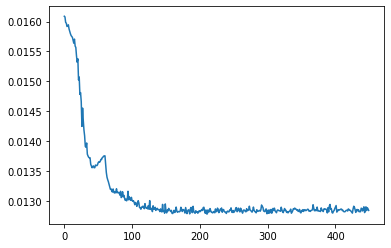

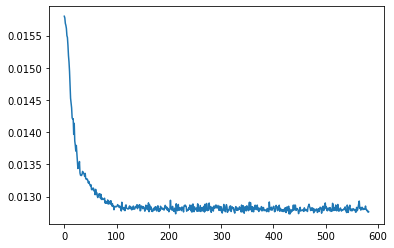

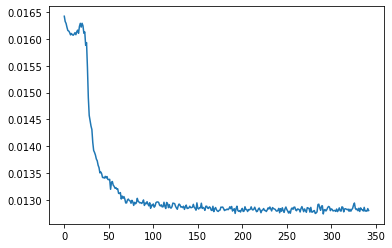

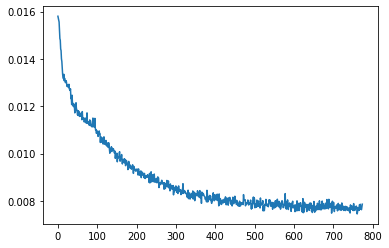

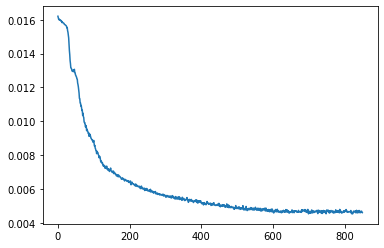

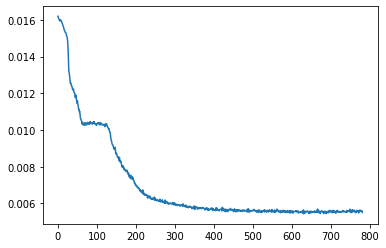

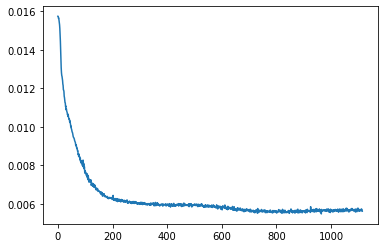

In [10]:
val_losses = []
for i in range(len(vae_histories)):
    plt.plot(vae_histories[i]["val_reconstruction_loss"])
    plt.show()
    val_losses.append(min(vae_histories[i]["val_reconstruction_loss"])) # val_reconstruction_loss

Text(0.5, 1.0, 'VAE validation reconstruction loss against beta (x-axis negative logarithmic)')

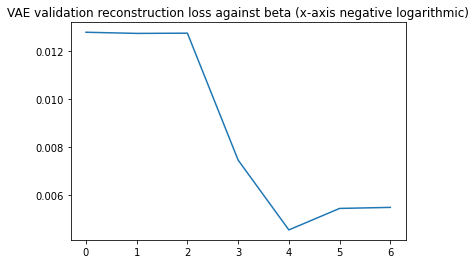

In [11]:
plt.plot(val_losses)

plt.title("VAE validation reconstruction loss against beta (x-axis negative logarithmic)")

## WAEs of varying beta

In [12]:
vaes = []
vae_histories = []
for beta in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    print(beta)
    name = f"wae_lbkeogh_mod_stats_beta={beta}_10"
    vae = general_load("Gen",name)
    
    vaes.append(vae)
    
    
    with open(f"data/losses/Gen/{name}.pickle", "rb") as file:
        vae_histories.append(pickle.load(file))


1
0.1
0.01
0.001
0.0001
1e-05
1e-06


1


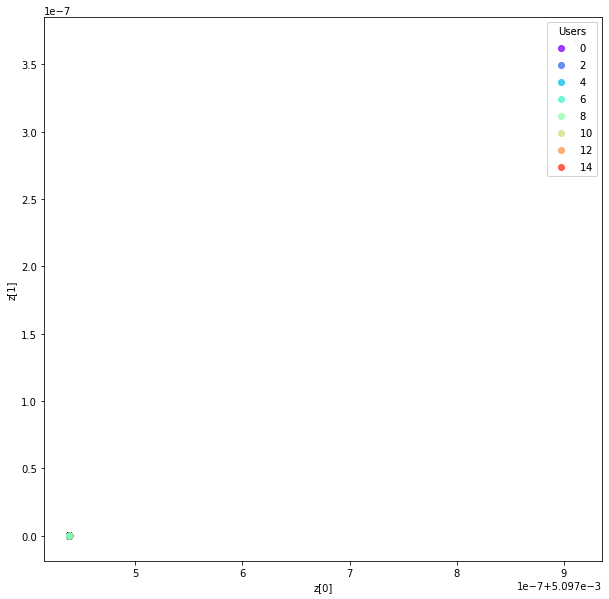

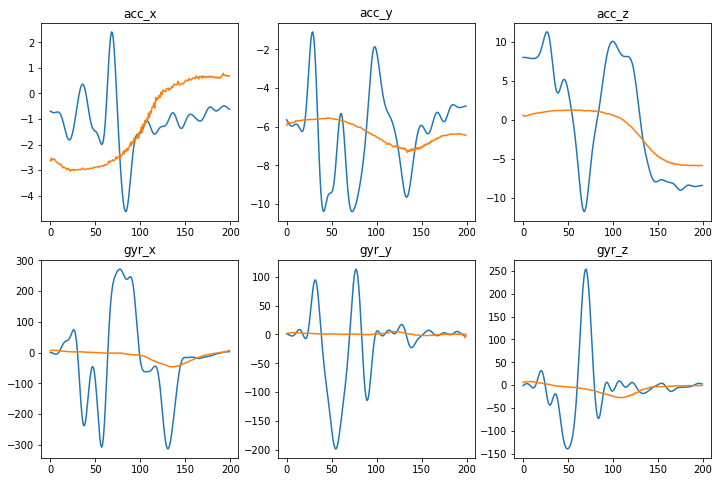

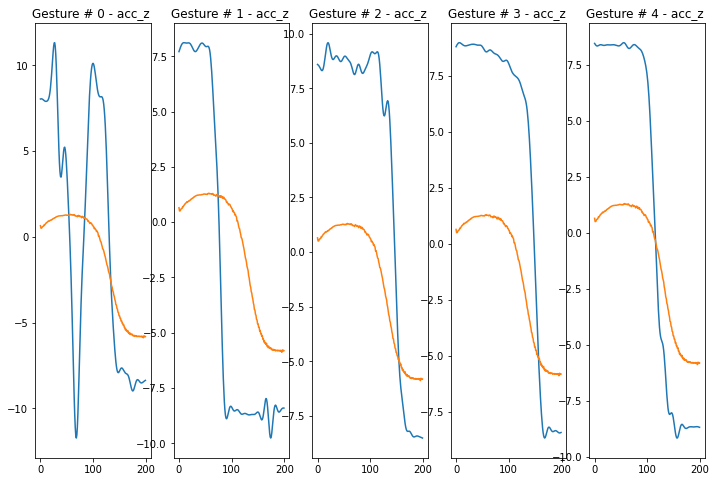

0.1


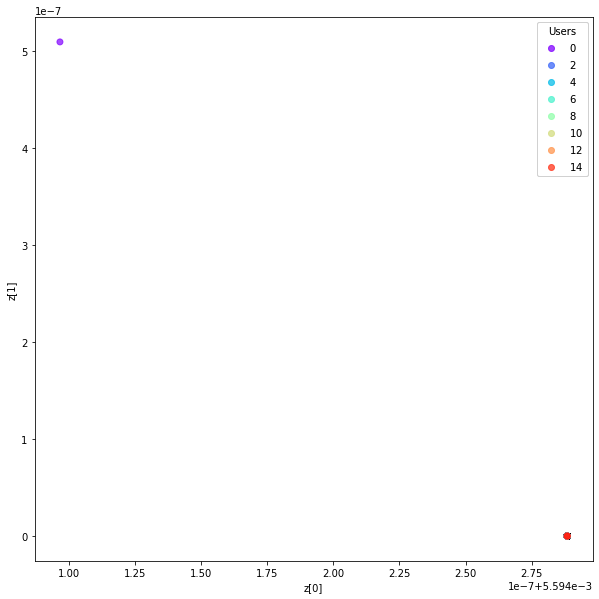

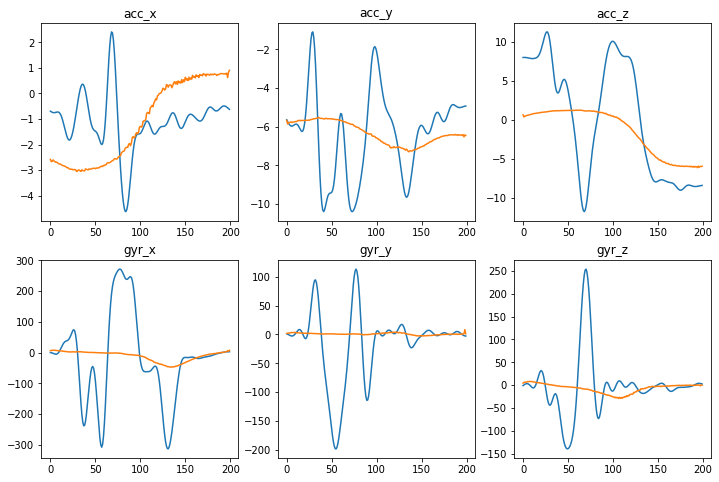

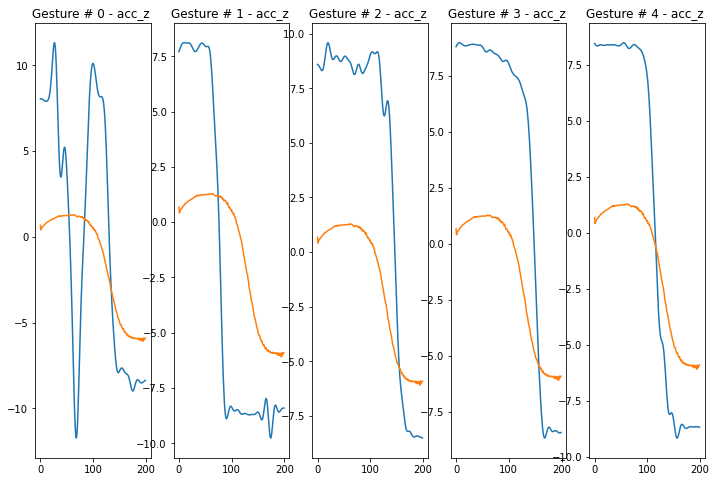

0.01


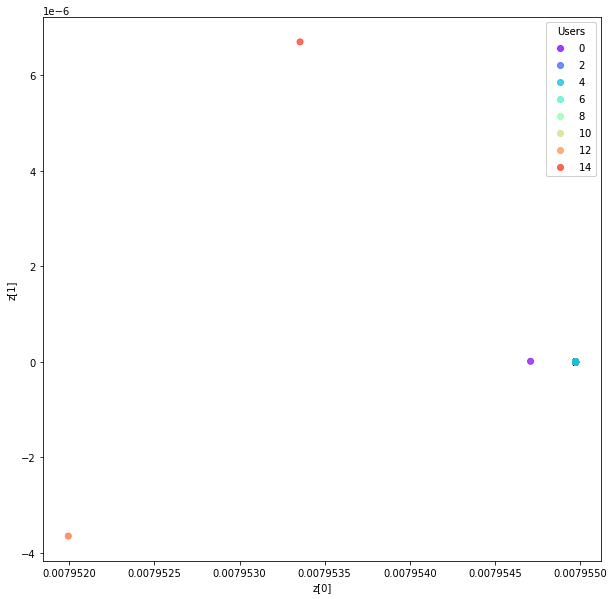

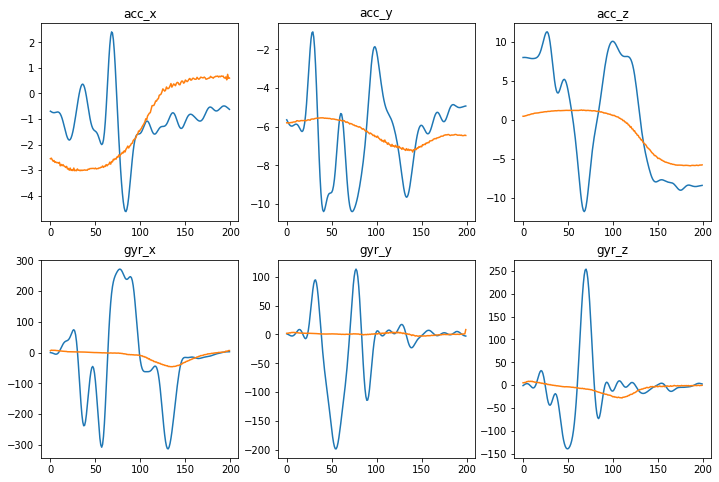

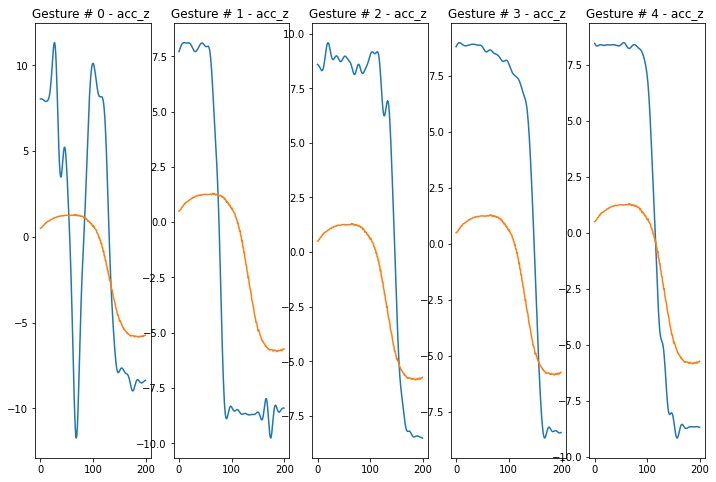

0.001


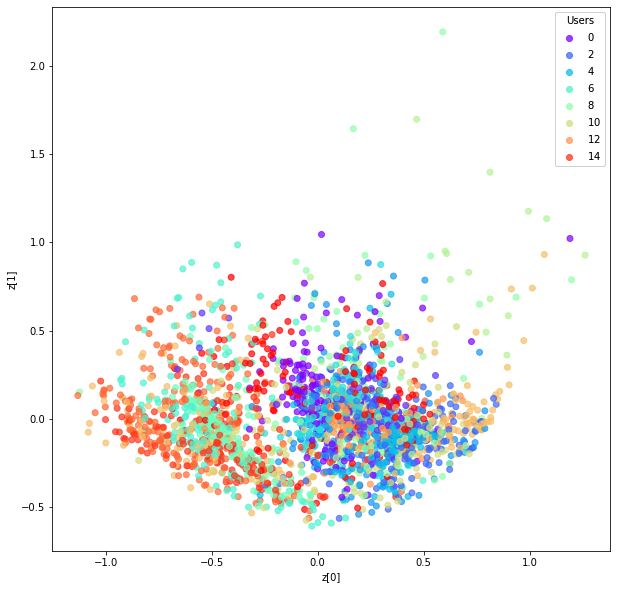

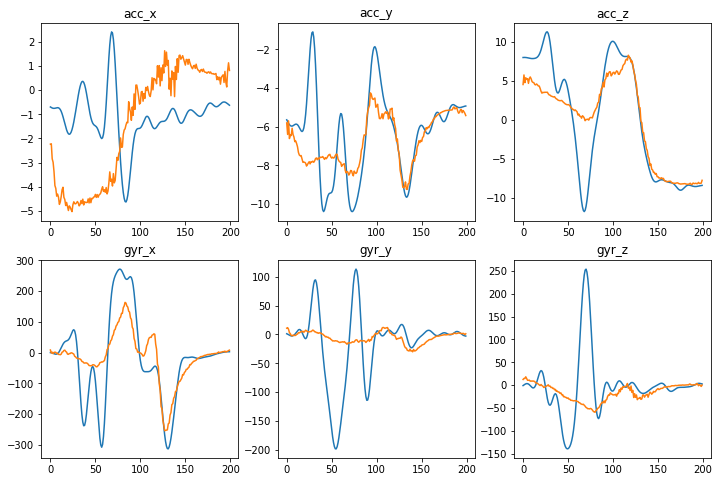

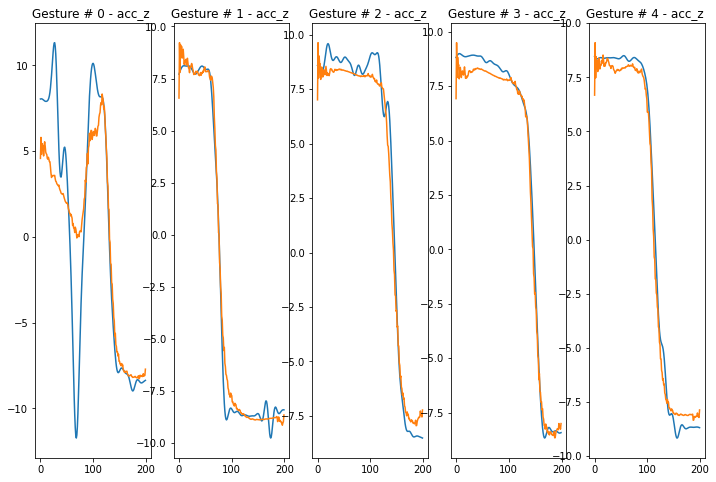

0.0001


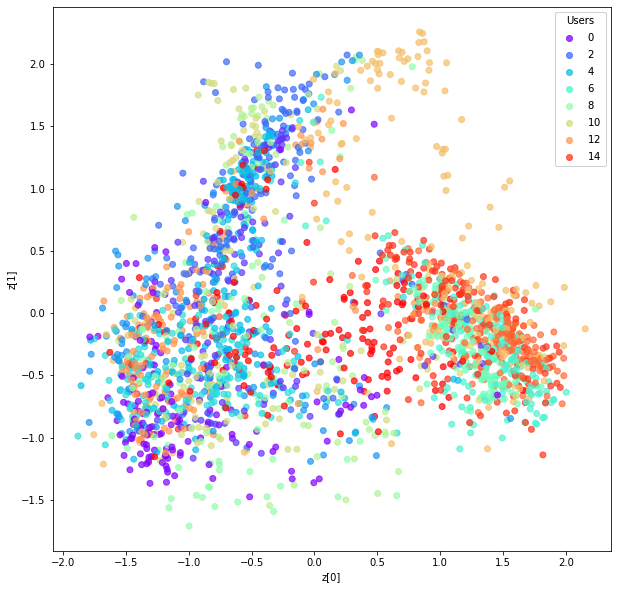

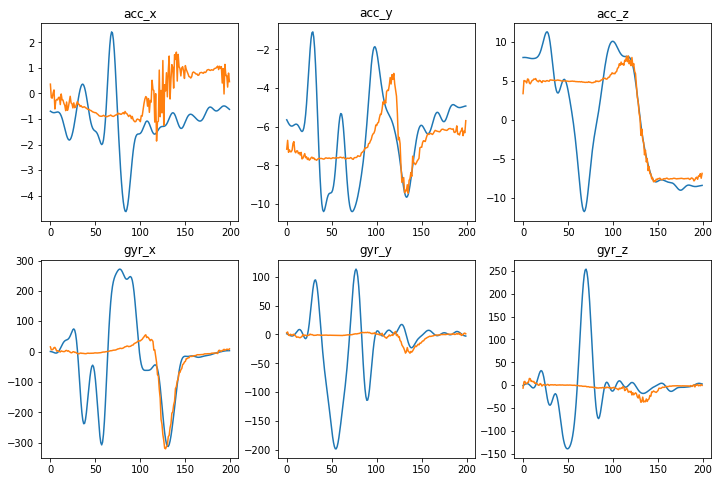

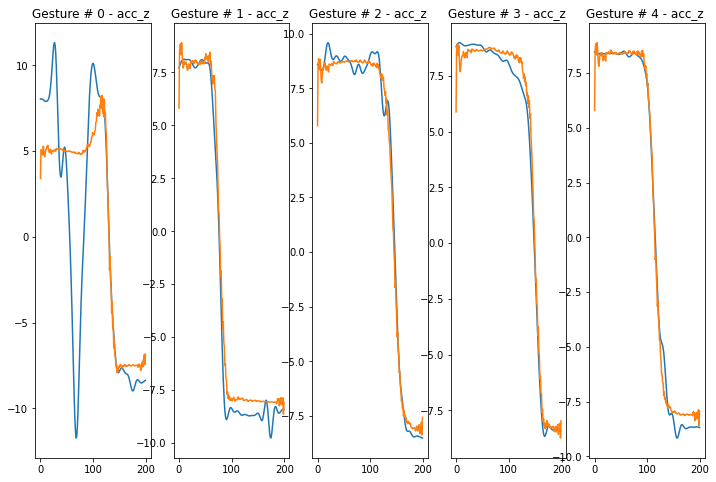

1e-05


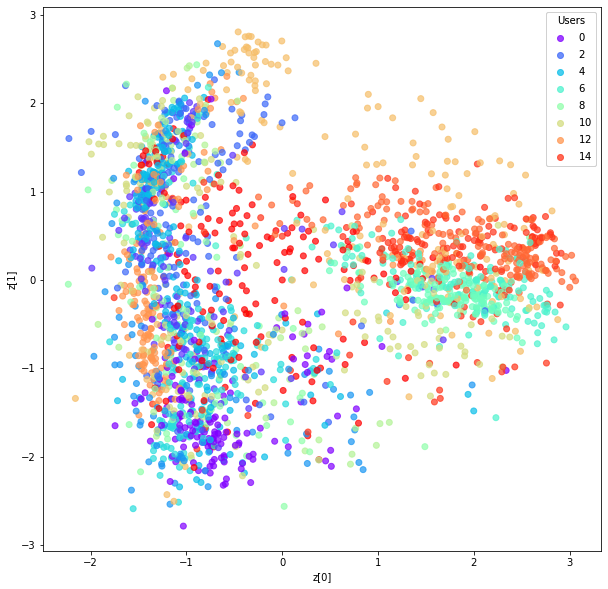

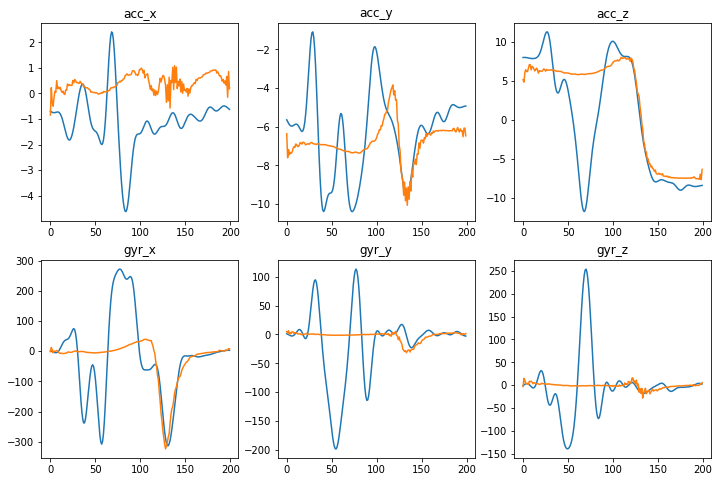

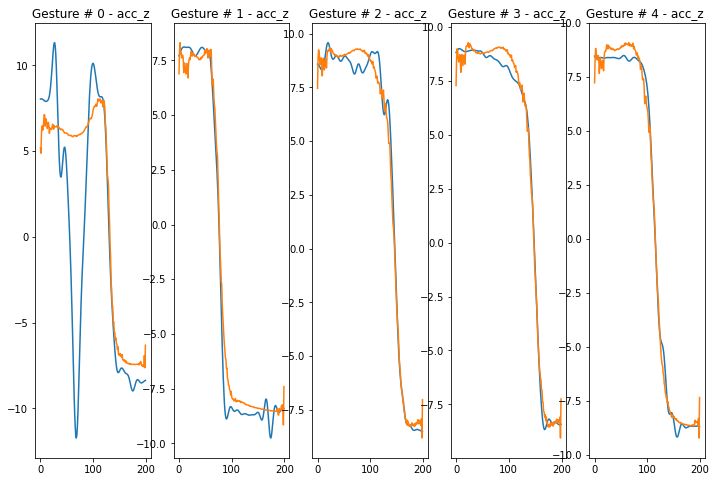

1e-06


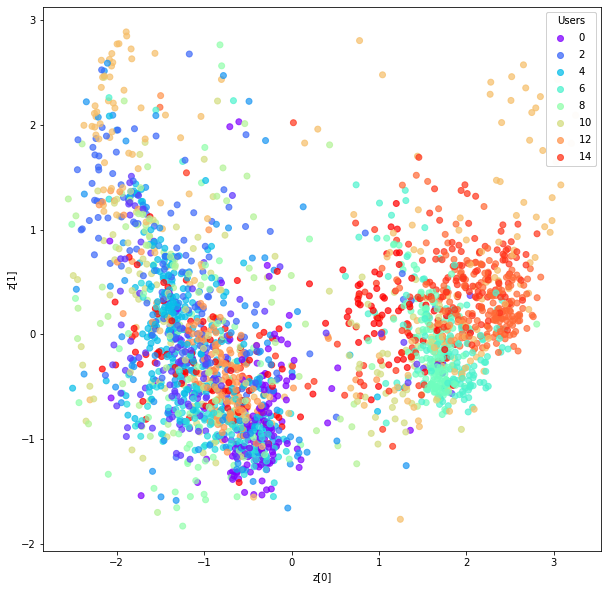

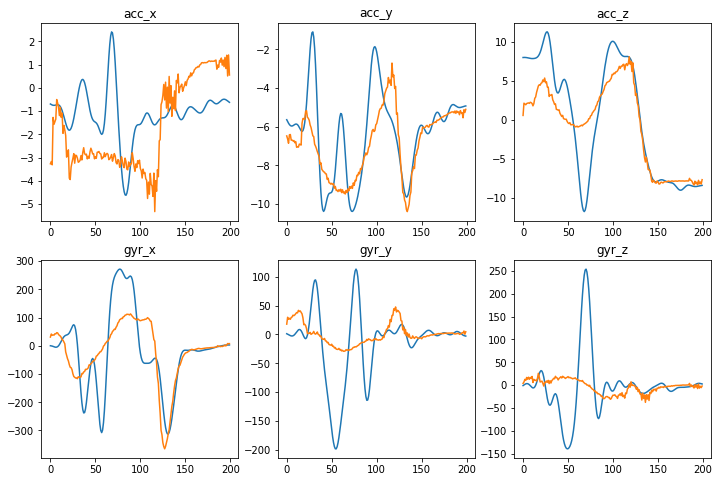

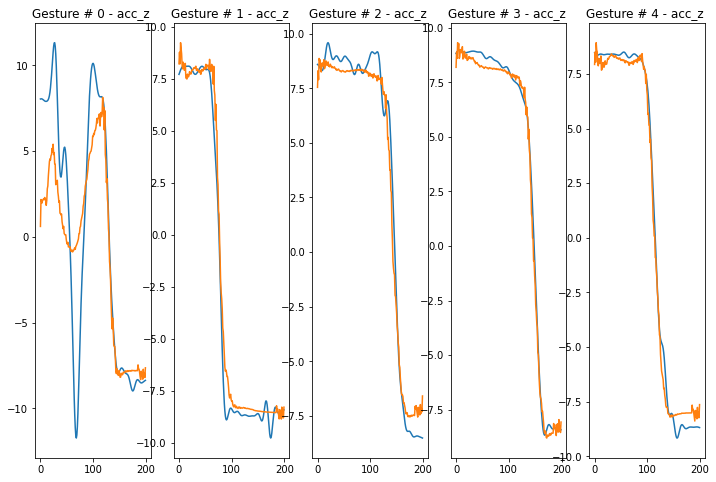

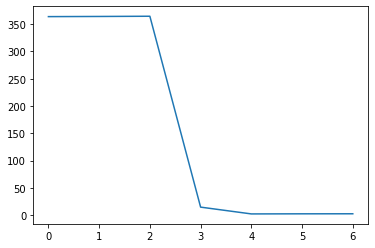

In [13]:
av_means = []
for i, vae in enumerate(vaes):
    print(10**-i)
    _map = (train_gesture_map == 1) #& (y_user.argmax(axis=1) >= 13)
    data = x_data[_map]
    z = vae.encoder(vae.scaler.transform(data))
    av_means.append( np.mean(np.linalg.norm(z, axis=1))) 
    enc = np.array(z)
    pca = PCA()
    plot_x = pca.fit_transform(enc)

    plot_pca12(plot_x, y_user.argmax(axis=1)[_map]) # do a version without user colouring?
    
    dec = vae.scaler.inverse_transform(vae.decoder(enc).cpu().numpy())

    plt = show_one_gesture_against_reconstruction(data[5], dec[5])
    plt.show()
    
    plt = show_multiple_gestures(data[5:], dec[5:], channel=2)
    plt.show()


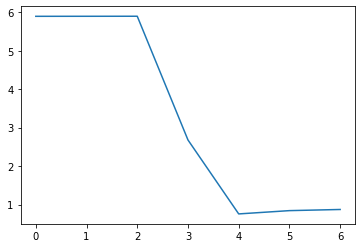

In [14]:

plt.plot(np.log(av_means))
plt.show()

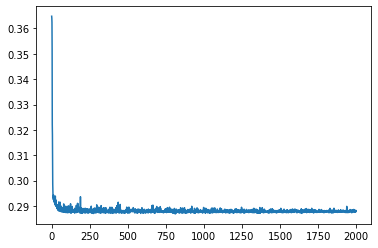

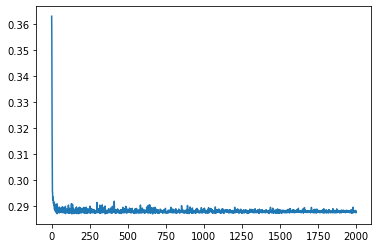

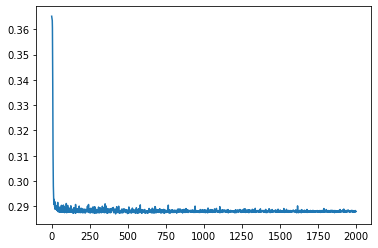

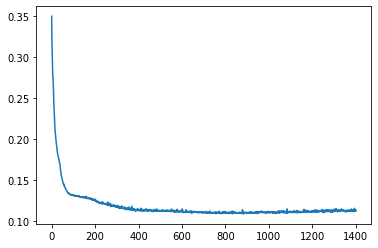

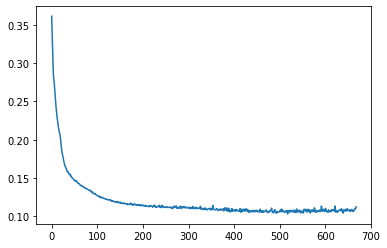

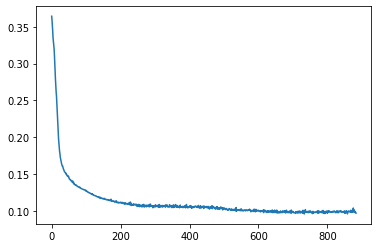

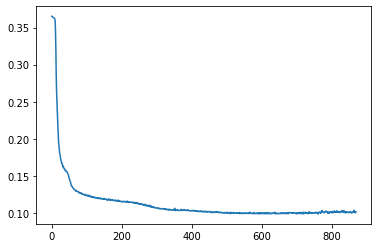

In [ ]:
val_losses = []
for i in range(len(vae_histories)):
    plt.plot(vae_histories[i]["val_reconstruction_loss"])
    plt.show()
    val_losses.append(min(vae_histories[i]["val_reconstruction_loss"])) # val_reconstruction_loss

Text(0.5, 1.0, 'WAE validation reconstruction loss against beta (x-axis negative logarithmic)')

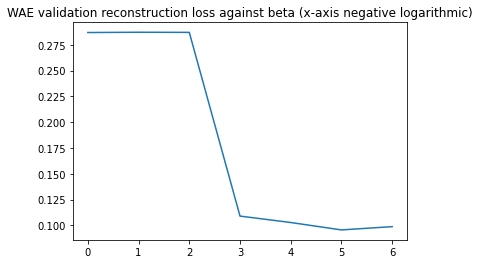

In [ ]:
plt.plot(val_losses)
plt.title("WAE validation reconstruction loss against beta (x-axis negative logarithmic)")

## VAEs of varying sizes - with auth

In [16]:
vaes = []
vae_histories = []
for alpha in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    print(alpha)
    name = f"vae_lbkeogh_mod_stats_auth_on_alpha={alpha}_10"
    vae = general_load("Gen",name)
    
    vaes.append(vae)
    
    
    with open(f"data/losses/Gen/{name}.pickle", "rb") as file:
        vae_histories.append(pickle.load(file))

        
# user 1e-2

1
0.1
0.01
0.001
0.0001
1e-05
1e-06


1
[[1.2976817  1.2467113  3.5006318  ... 1.0059255  1.005691   1.0238363 ]
 [1.2908199  1.2403324  3.4419925  ... 1.0055263  1.0056392  1.0228525 ]
 [1.3291856  1.2814322  3.7214468  ... 1.0077294  1.0075179  1.0254009 ]
 ...
 [0.77407926 0.8144773  0.64941853 ... 0.99587697 0.99100894 0.99799806]
 [0.8206432  0.83539283 0.7036307  ... 0.99748814 0.98601115 1.031954  ]
 [0.73219436 0.72330207 0.46625307 ... 1.002306   0.99065226 1.0678478 ]]


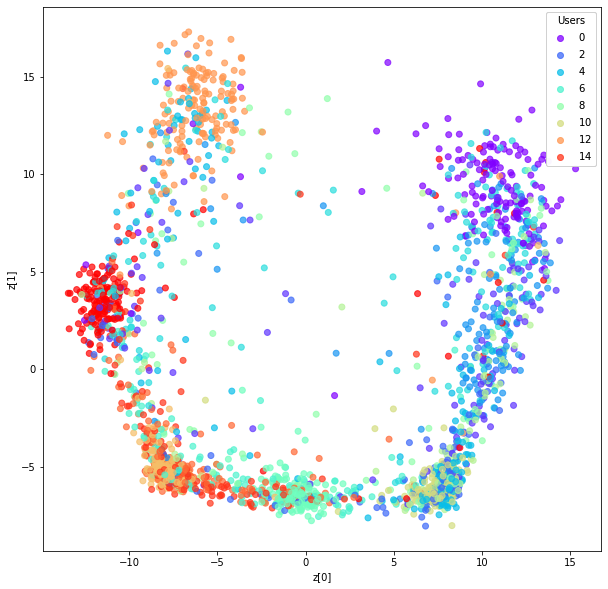

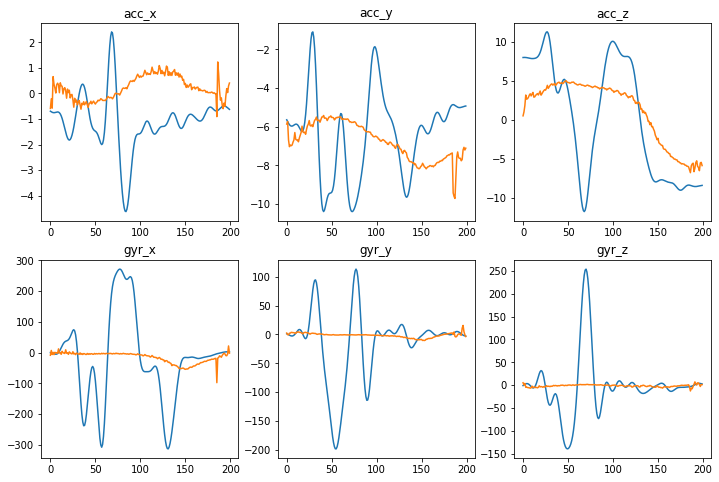

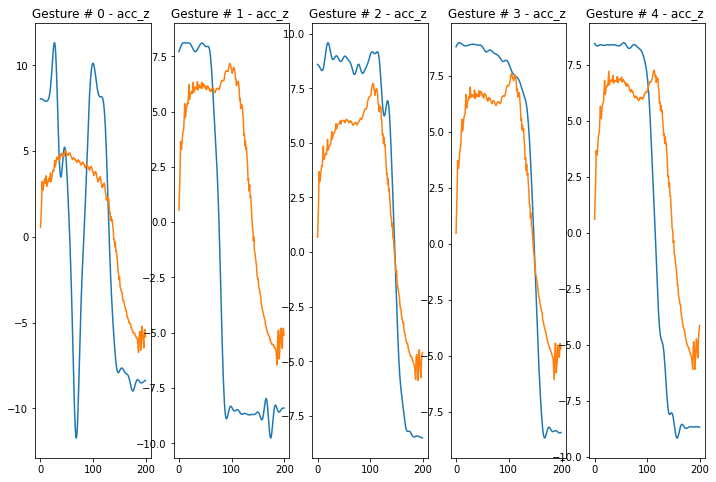

0.1
[[0.74250615 0.6670776  0.8176618  ... 0.98130053 0.9670557  0.89059067]
 [0.7138536  0.6794478  0.82044953 ... 0.990773   0.98041934 0.89771056]
 [0.7035538  0.70242465 0.8275235  ... 1.0135775  1.0164827  0.9183843 ]
 ...
 [0.6520428  0.6137033  0.8307428  ... 1.00072    1.0208558  0.9801771 ]
 [0.7185733  0.8216955  0.8794793  ... 1.0089406  1.0137781  0.933118  ]
 [0.713671   0.67069685 0.8192818  ... 0.98681325 0.97506887 0.89845985]]


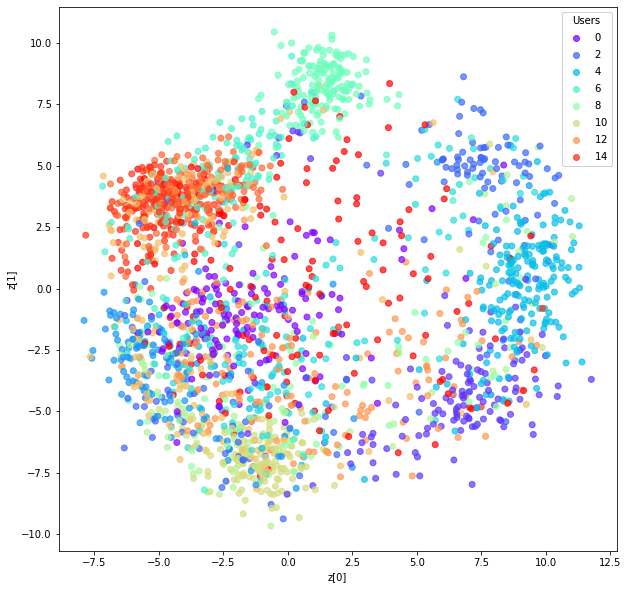

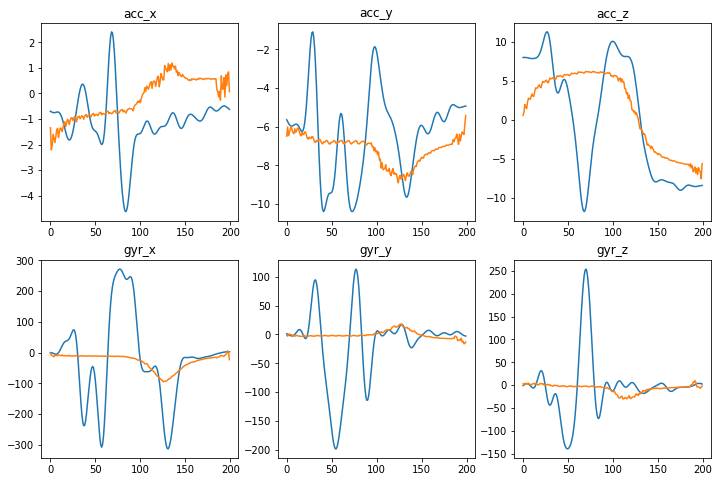

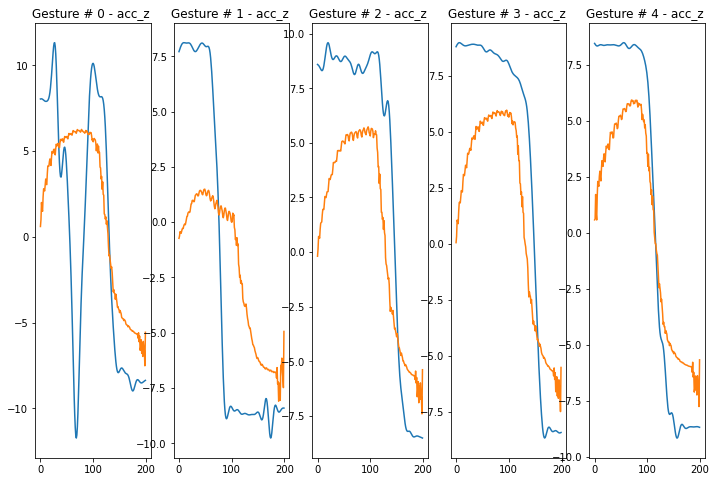

0.01
[[0.04681781 0.03785766 0.9748949  ... 0.97432154 0.97350824 0.05015051]
 [0.04768464 0.03537722 0.97814006 ... 0.97437686 0.9738113  0.04648419]
 [0.06217225 0.05635642 0.97338957 ... 0.9733522  0.977588   0.06117338]
 ...
 [0.05114566 0.02540812 0.9776982  ... 0.97946185 0.9841582  0.05499963]
 [0.11592014 0.07858025 0.9864949  ... 0.987424   0.9893276  0.08102177]
 [0.08540479 0.05299091 0.98337203 ... 0.9823381  0.9844161  0.07221089]]


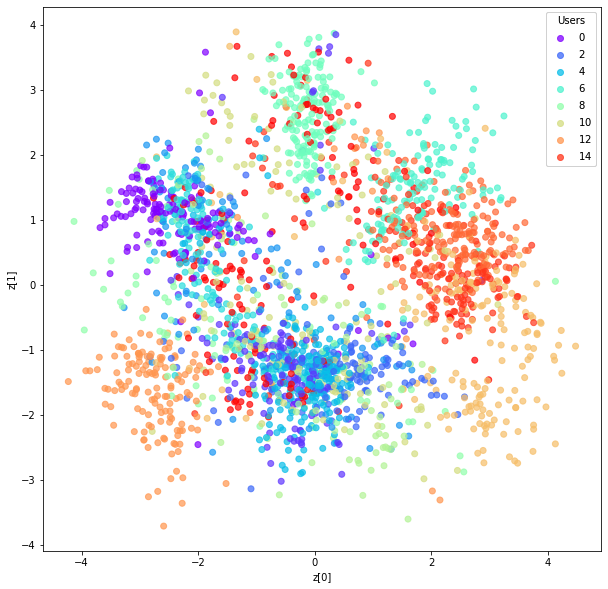

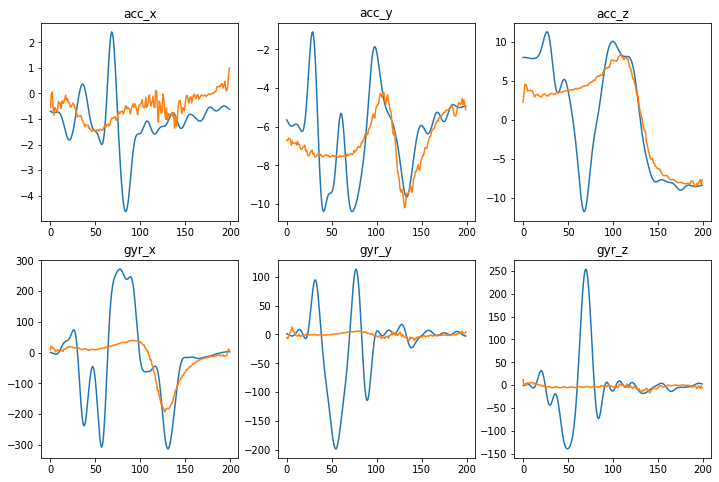

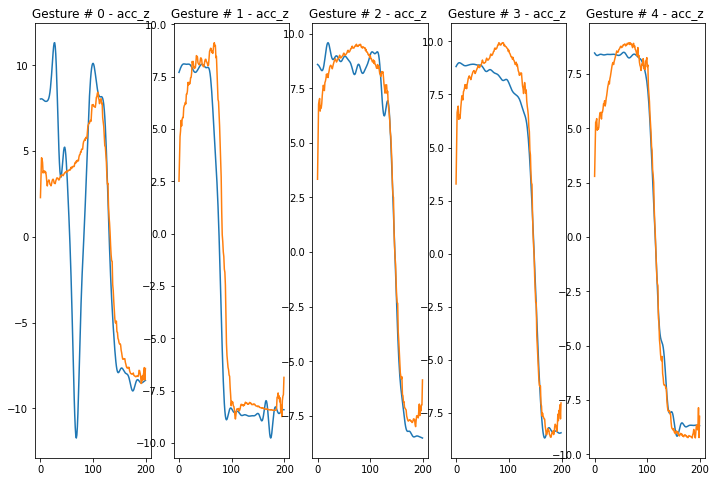

0.001
[[1.030023   0.11940962 0.97809553 ... 0.04588616 0.9801072  0.977715  ]
 [1.0285182  0.11483757 0.97588444 ... 0.04456363 0.97755694 0.9748942 ]
 [1.0317003  0.1601845  0.9808156  ... 0.06060634 0.9795473  0.9779068 ]
 ...
 [0.9473789  0.15696242 0.98723763 ... 0.06746273 0.9825338  0.9777044 ]
 [0.9089093  0.22793241 0.9955078  ... 0.10227533 0.980755   0.980564  ]
 [0.94698215 0.14648193 0.98500305 ... 0.06343723 0.9817727  0.97587913]]


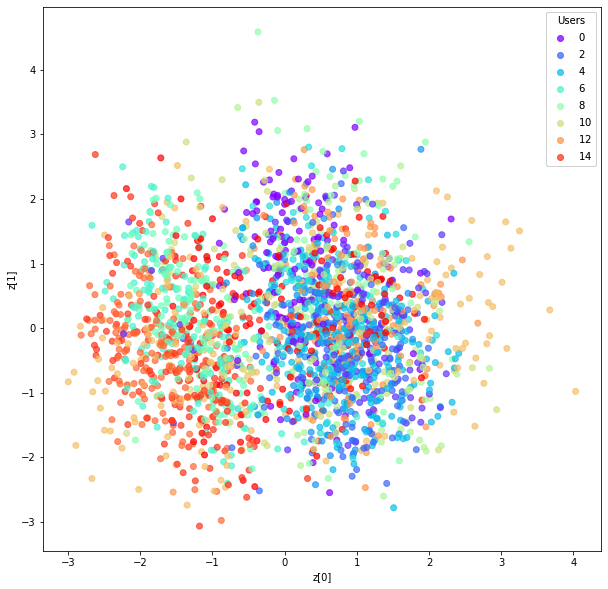

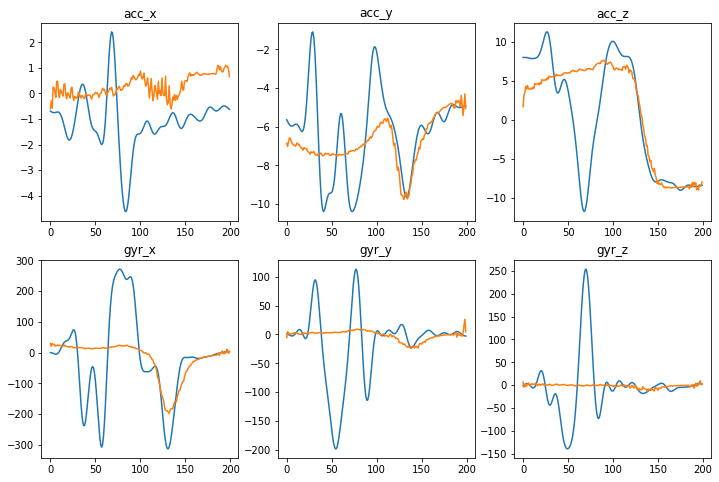

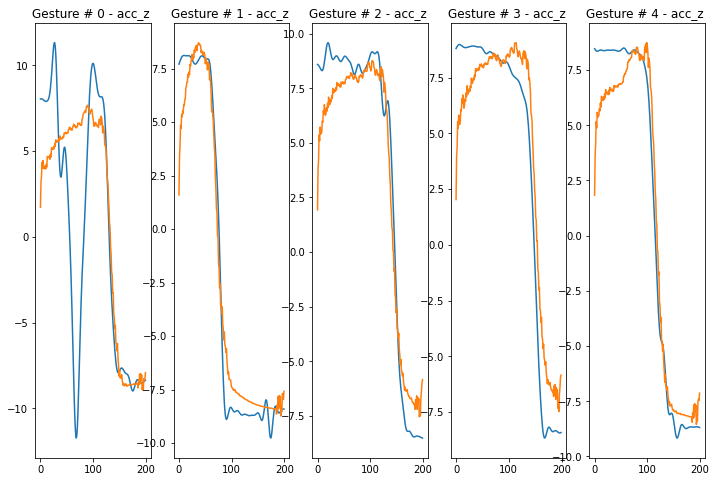

0.0001
[[0.98362887 0.01805748 0.977668   ... 0.03723787 0.97317845 0.9794617 ]
 [0.98627925 0.01744062 0.982576   ... 0.03513081 0.97632104 0.98210204]
 [0.98598593 0.02616865 0.9857908  ... 0.05466571 0.98052675 0.9852266 ]
 ...
 [0.99500686 0.02271504 1.0055356  ... 0.02653361 0.98442334 0.9870989 ]
 [1.0001153  0.05917904 0.9978135  ... 0.09083198 0.99750745 0.9992831 ]
 [0.9952316  0.03674838 0.99555016 ... 0.06112523 0.9860372  0.9900857 ]]


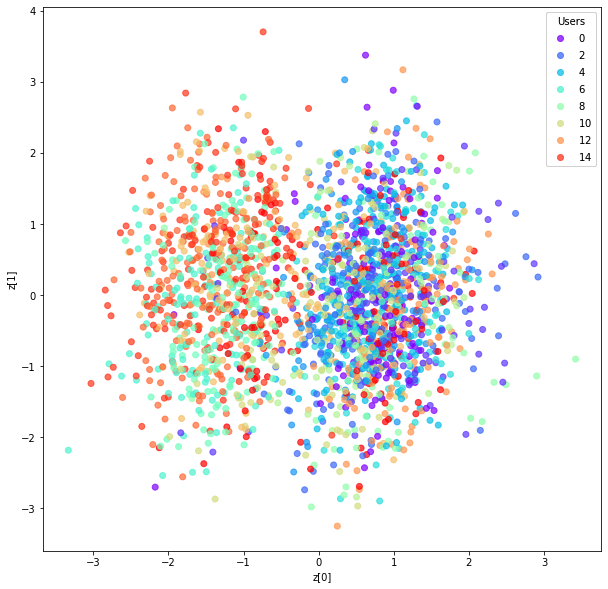

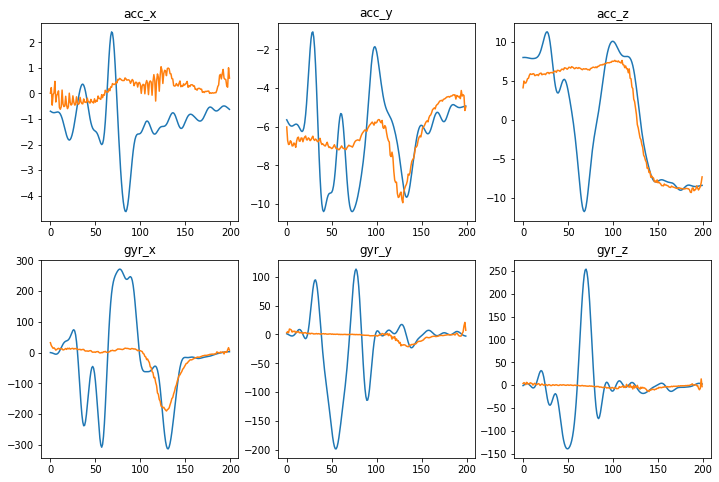

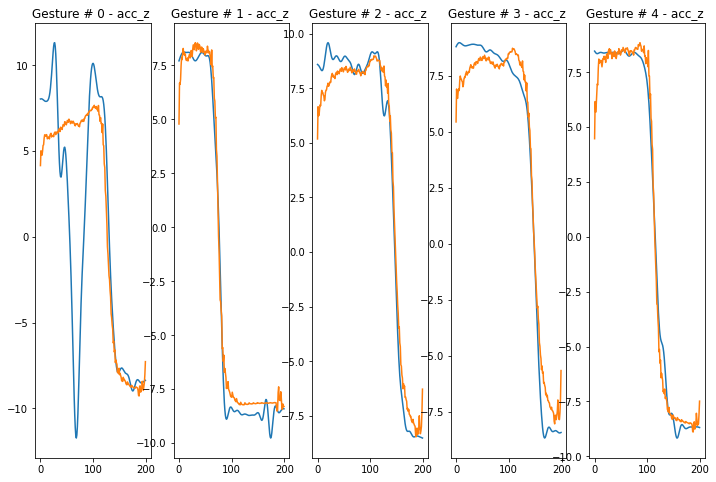

1e-05
[[0.98200816 0.11504469 0.98704344 ... 0.02378359 0.98267317 0.9927898 ]
 [0.9818594  0.10968903 0.9872658  ... 0.02295592 0.9821762  0.9934256 ]
 [0.9772941  0.14305398 0.98378867 ... 0.03419233 0.98014534 0.9876888 ]
 ...
 [0.99182814 0.14052956 1.0049192  ... 0.03304228 0.99814713 1.0055692 ]
 [0.98713267 0.16870695 1.0001565  ... 0.04457815 0.99217194 0.99851036]
 [0.9904015  0.14321615 1.0054327  ... 0.03268652 0.9973508  1.0050137 ]]


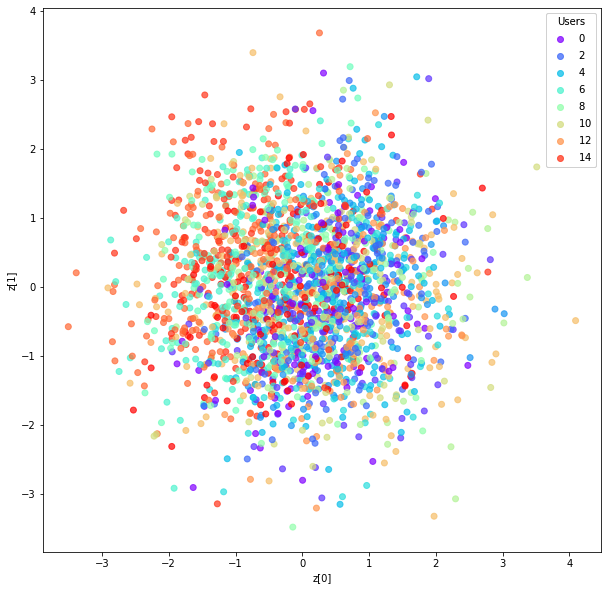

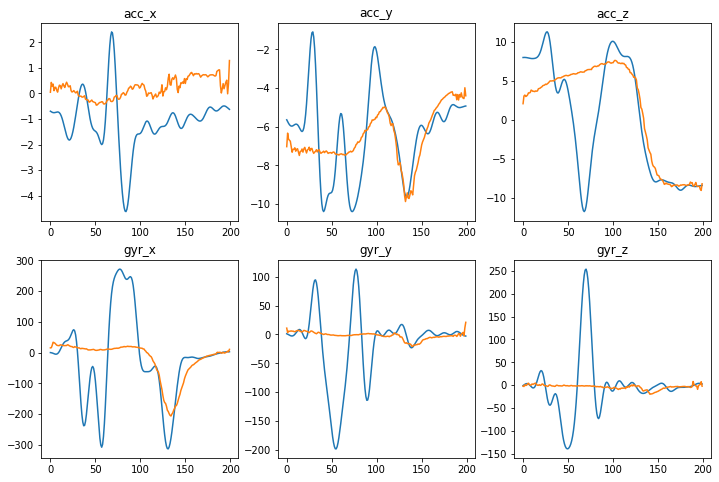

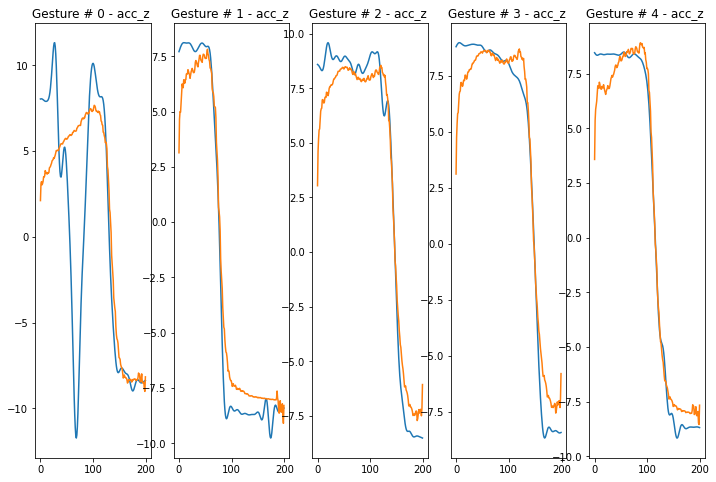

1e-06
[[0.99176854 0.9940865  0.99120635 ... 0.08082541 0.99203056 1.0017402 ]
 [0.9906346  0.9932874  0.98995584 ... 0.07780921 0.99046624 1.0000763 ]
 [0.99084574 0.9916966  0.98915684 ... 0.11087701 0.99212253 0.996161  ]
 ...
 [0.99280787 0.9945098  0.9886872  ... 0.08354428 0.99068564 1.0008243 ]
 [0.98277545 0.98104286 0.97583115 ... 0.1705719  0.9822439  0.9872666 ]
 [0.9885136  0.9926256  0.98660946 ... 0.10055663 0.98887926 0.9948327 ]]


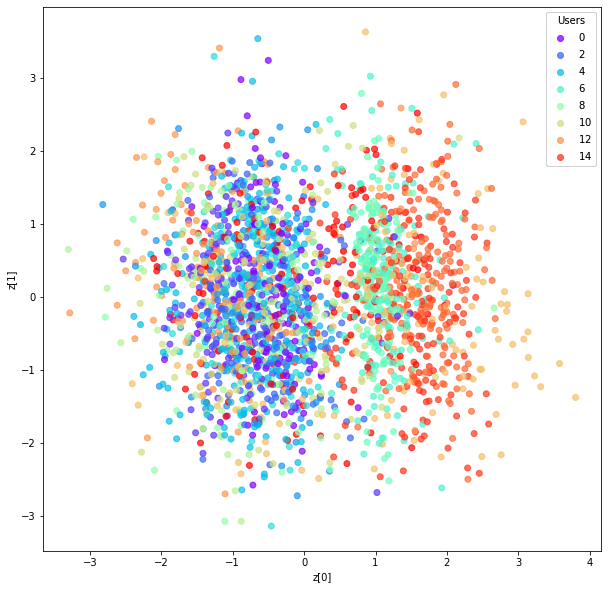

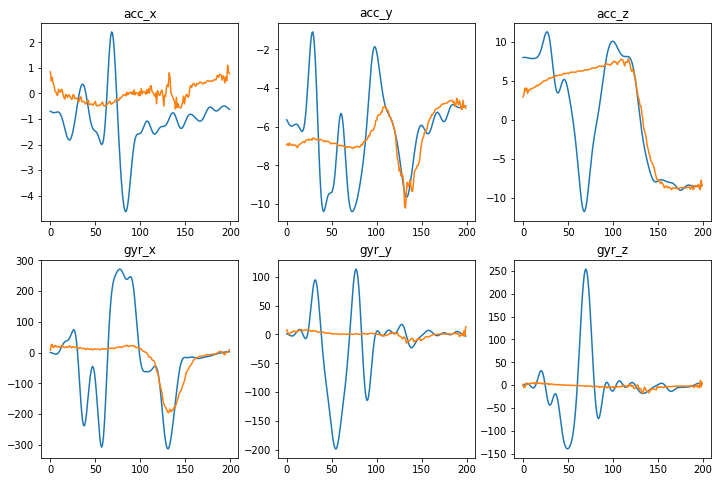

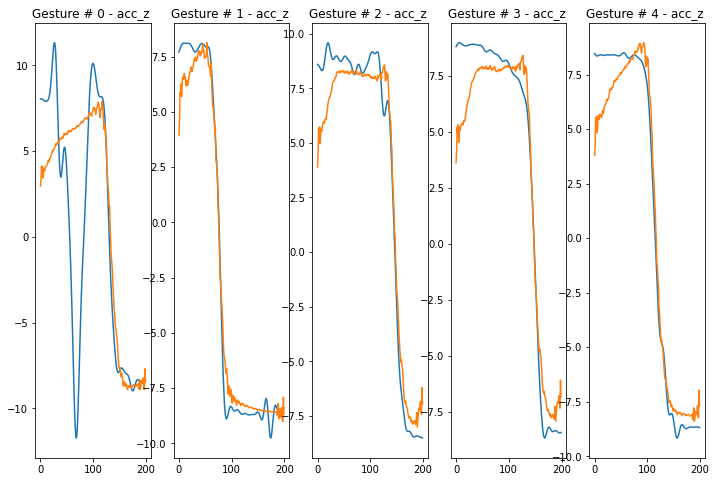

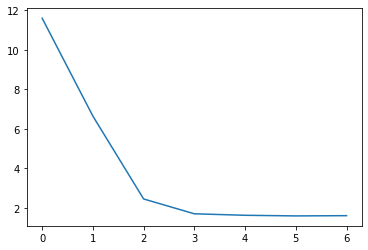

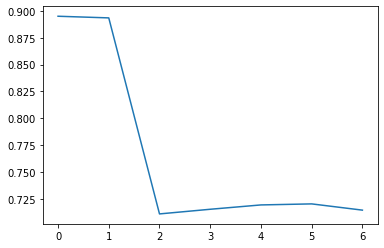

[11.597947   6.645005   2.4547937  1.7037984  1.6289817  1.5968553
  1.6099175]
[0.8949649, 0.8934316, 0.7109856, 0.7153168, 0.7193526, 0.72031313, 0.71450293]


In [17]:
av_means = []
av_stds = []
for i, vae in enumerate(vaes):
    print(10**-i)
    _map = (train_gesture_map == 1) #& (y_user.argmax(axis=1) >= 13)
    data = x_data[_map]
    z_mean, z_log_var, z = vae.encoder(vae.scaler.transform(data))
    av_means.append( np.mean(np.linalg.norm(z_mean, axis=1))) 
    av_stds.append( np.mean(abs(np.exp(0.5 * z_log_var)))) 
    
    enc = np.array(z)
    print(np.exp(0.5 * z_log_var))
    pca = PCA()
    plot_x = pca.fit_transform(enc)

    plot_pca12(plot_x, y_user.argmax(axis=1)[_map]) # do a version without user colouring?
    
    # Do a TSNE plot!
    
    dec = vae.scaler.inverse_transform(vae.decoder(enc).cpu().numpy())

    plt = show_one_gesture_against_reconstruction(data[5], dec[5])
    plt.show()
    
    plt = show_multiple_gestures(data[5:], dec[5:], channel=2)
    plt.show()

plt.plot(av_means)
plt.show()
plt.plot(av_stds)
plt.show()
print(np.array(av_means))
print(av_stds)

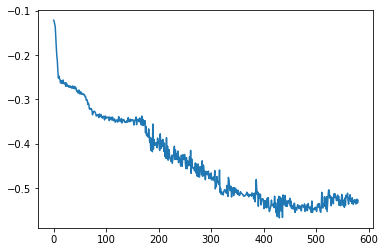

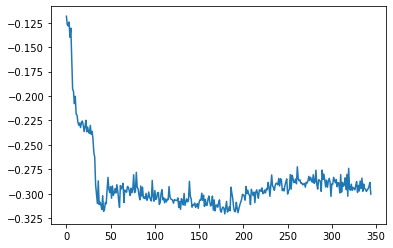

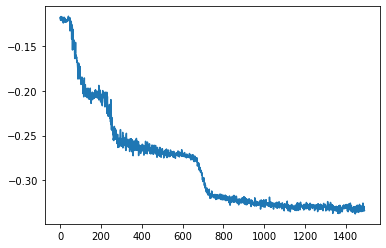

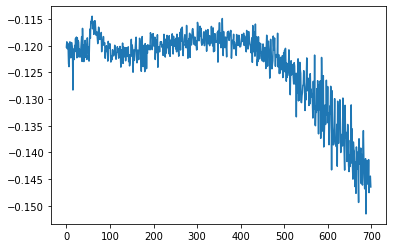

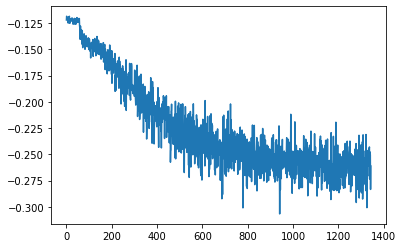

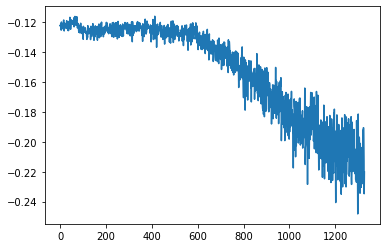

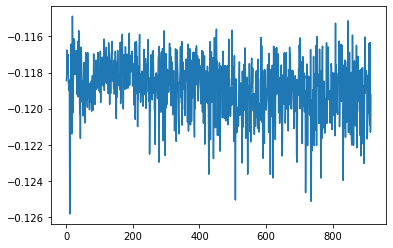

In [18]:
val_losses = []
for i in range(len(vae_histories)):
    plt.plot(vae_histories[i]["val_auth_loss"])
    plt.show()
    val_losses.append(min(vae_histories[i]["val_auth_loss"])) # val_reconstruction_loss

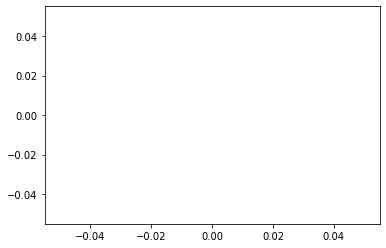

In [7]:
plt.plot(val_losses)

#plt.title("VAE validation reconstruction loss against beta (x-axis negative logarithmic)")

## WAEs of varying alpha

In [8]:
vaes = []
vae_histories = []
for alpha in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    print(alpha)
    name = f"wae_lbkeogh_mod_stats_auth_on_alpha={alpha}_10"
    vae = general_load("Gen",name)
    
    vaes.append(vae)
    
    
    with open(f"data/losses/Gen/{name}.pickle", "rb") as file:
        vae_histories.append(pickle.load(file))

alpha = 1e-2

NameError: name 'beta' is not defined

In [9]:
av_means = []
av_stds = []
for i, vae in enumerate(vaes):
    print(10**-i)
    _map = (train_gesture_map == 1) #& (y_user.argmax(axis=1) >= 13)
    data = x_data[_map]
    z = vae.encoder(vae.scaler.transform(data))
    
    enc = np.array(z)
    pca = PCA()
    plot_x = pca.fit_transform(enc)

    plot_pca12(plot_x, y_user.argmax(axis=1)[_map]) # do a version without user colouring?
    
    dec = vae.scaler.inverse_transform(vae.decoder(enc).cpu().numpy())

    plt = show_one_gesture_against_reconstruction(data[5], dec[5])
    plt.show()
    
    plt = show_multiple_gestures(data[5:], dec[5:], channel=2)
    plt.show()


In [10]:
val_losses = []
for i in range(len(vae_histories)):
    plt.plot(vae_histories[i]["auth_loss"])
    plt.plot(vae_histories[i]["val_auth_loss"])
    plt.show()
    val_losses.append(min(vae_histories[i]["val_auth_loss"])) # val_reconstruction_loss

Text(0.5, 1.0, 'WAE validation reconstruction loss against beta (x-axis negative logarithmic)')

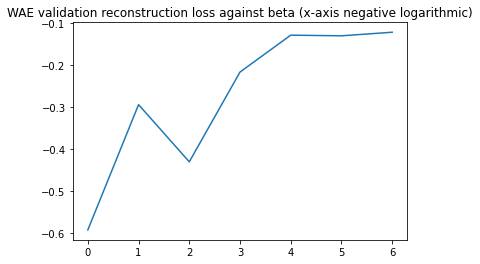

In [30]:
plt.plot(val_losses)
plt.title("WAE validation reconstruction loss against beta (x-axis negative logarithmic)")

## Visualising latent space of test gestures

In [ ]:
vae = general_load(f"Gen", "vae_final_10")

In [ ]:
auth_user = 10
_map = (train_gesture_map == 1) | (test_gesture_map == 1)
data = x_data[_map]
enc = vae.encoder(vae.scaler.transform(data))[0] # [0]

pca = PCA()
plot_x = pca.fit_transform(enc[:, :5])


mapped_users = np.zeros(len(y_user))
mapped_users += (y_user.argmax(axis=1) == auth_user).astype(int)
mapped_users += ((y_user.argmax(axis=1) == auth_user) & (test_gesture_map == 1)).astype(int)
labels = mapped_users[_map]
#print(max(mapped_users))

visualise_TSNE(plot_x, labels)
#plot_pca12(plot_x, labels)
#plot_label_clusters(plot_x, labels)


## Visualising latent space of gesture without being trained on that gesture

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


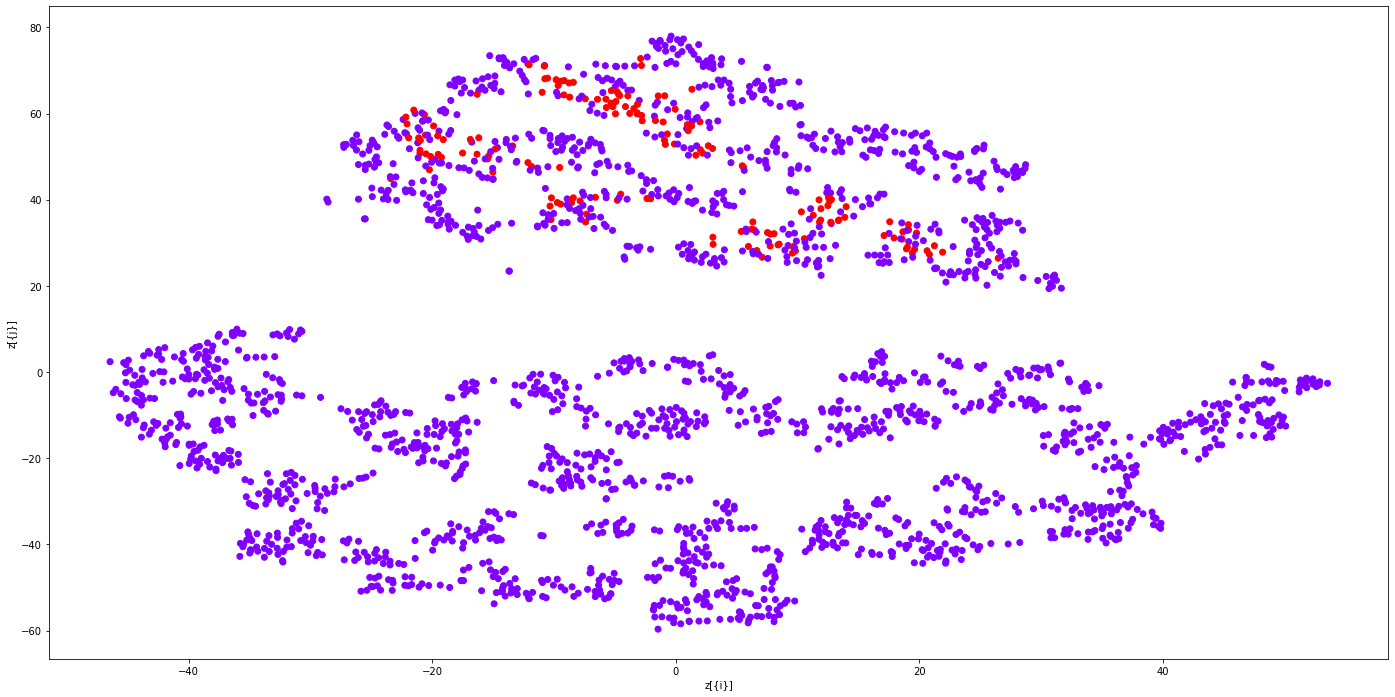

In [8]:
auth_user = 7

vae = general_load(f"Gen/user={auth_user}", "wae_final_10")


_map = (train_gesture_map == 1)
data = x_data[_map]
enc = vae.encoder(vae.scaler.transform(data)) # [0]

pca = PCA()
plot_x = pca.fit_transform(enc)


visualise_TSNE(plot_x, y_user.argmax(axis=1)[_map] == auth_user)

In [31]:


def plot_standard_devs(vae, data, labels, pca=None):
    # display a 2D plot showing the areas of impact of different points
    z_mean, z_log_var, z = vae.encoder.predict(data)
    if pca is None:
        pca = PCA()
        z_pca = pca.fit_transform(z_mean)
    else:
        z_pca = pca.transform(z_mean)

    z_log_var = pca.transform(z_log_var)

    plt.scatter(z_pca[:,0], latent_space_means[:,1], c = range(len(data)), label="means")
    plt.scatter(latent_space[:,0], latent_space[:,1], label="sampled", c = range(10), s=10)

    plt.legend()
    
    plt.show()
    
    # create 2 kernels
    m1 = (-1,-1)
    s1 = np.eye(2)
    k1 = multivariate_normal(mean=m1, cov=s1)

    m2 = (1,1)
    s2 = np.eye(2)
    k2 = multivariate_normal(mean=m2, cov=s2)

    # create a grid of (x,y) coordinates at which to evaluate the kernels
    xlim = (-3, 3)
    ylim = (-3, 3)
    xres = 100
    yres = 100

    x = np.linspace(xlim[0], xlim[1], xres)
    y = np.linspace(ylim[0], ylim[1], yres)
    xx, yy = np.meshgrid(x,y)

    # evaluate kernels at grid points
    xxyy = np.c_[xx.ravel(), yy.ravel()]
    zz = k1.pdf(xxyy) + k2.pdf(xxyy)

    # reshape and plot image
    img = zz.reshape((xres,yres))
    plt.imshow(img); plt.show()



def plot_label_clusters(vae, data, labels, pca=None, is_wae=False, top_5 = False):
    # display a 2D plot of the user classes in the latent space
    if is_wae:
        z_mean = vae.encoder.predict(data)
    else:
        z_mean, z_log_var, z = vae.encoder.predict(data)
    if top_5:
        z_mean = z_mean[:, :5]
    if pca is None:
        pca = PCA()
        z_pca = pca.fit_transform(z_mean)
    else:
        z_pca = pca.transform(z_mean)
    
    comps = 5

    pair_set = [(i,j) for i in range(comps) for j in range(i+1,comps)]
    
    fig, ax = plt.subplots(1 + len(pair_set)//3,3, figsize=(24,48))
    
    for ix, (i,j) in enumerate(pair_set):
        scatter = ax[divmod(ix, 3)].scatter(z_pca[:, i], z_pca[:, j], c=labels, alpha=0.7, cmap = "rainbow")
        ax[divmod(ix, 3)].set_xlabel(f"z[{i}]")
        ax[divmod(ix, 3)].set_ylabel(f"z[{j}]")
        legend = ax[divmod(ix, 3)].legend(*scatter.legend_elements(),
                    loc="upper right", title="Users")
        ax[divmod(ix, 3)].add_artist(legend)
    #plt.colorbar()
    
    plt.show()

def visualise(vae, data, labels, latent_dim=20, pca=None,
              is_wae=False, top_5=False):
    # display a 2D plot of the user classes in the latent space
    if is_wae:
        z_mean = vae.encoder.predict(data)
    else:
        z_mean, z_log_var, z = vae.encoder.predict(data)
    if top_5:
        z_mean = z_mean[:, :5]
    if pca is None:
        pca = PCA(min(z_mean.shape[1], 20))
        z_pca = pca.fit_transform(z_mean)
        #z_pca = z_mean
    else:
        z_pca = pca.transform(z_mean)
    
    df = dimension_reduction(z_pca, labels)

    fig, ax = plt.subplots(1,1, figsize=(24,12) ) # , subplot_kw={"projection": "3d"})# , 
                           
    ax.scatter(df["dimension 1"], df["dimension 2"],  c = df["labels"], cmap = "rainbow") #  df["dimension 3"],
    ax.set_xlabel("z[{i}]")
    ax.set_ylabel("z[{j}]")
    #plt.colorbar()
    
    plt.show()



"""    
intent_x = np.array(list(x_data[:1000])+list(x_data[-1000:]))
intent_y = np.array(list(y_intent[:1000]) + list(y_intent[-1000:]))

gesture_x = x_data[:600]
gesture_y = y_gesture.argmax(axis=1)[:600]

_map = (y_intent == 1) & ((y_user.argmax(axis=1) == 13) | (y_user.argmax(axis=1) == 14) | (y_user.argmax(axis=1) == 15))

user_x = x_data[_map]
user_y = y_user.argmax(axis=1)[_map]


#plot_label_clusters(vae, intent_x, intent_y, pca)
plot_label_clusters(vae, user_x, user_y, pca)
#plot_label_clusters(vae, gesture_x, gesture_y, pca)

visualise(vae, user_x, user_y, pca)
#visualise(vae, intent_x, intent_y)
#visualise(vae, gesture_x, gesture_y, pca)
"""


def plot_reconstructed_curves(vae, data, channel=0, is_wae=False):
    fig,ax = plt.subplots(2,5, figsize=(12,8))
    j = 0

    for i in random.sample(range(0, len(data)), 5):
        enc = vae.encoder.predict(data[i:i+1]) #vae.scaler.transform(
        if not is_wae:
            enc = enc[0] 
        dec = vae.scaler.inverse_transform(vae.decoder.predict(enc))
        ax[divmod(j,5)].plot(vae.scaler.inverse_transform(data)[i,:,channel])
        ax[divmod(j,5)].plot(dec[0,:,channel])

        j += 1

    plt.show()

    

"""
fig,ax = plt.subplots(2,8, figsize=(24,16))

filtered = x_data[y_intent==1]

for i in random.sample(range(0, len(filtered)), 1):
    for k in range(4):
        enc = vae.encoder.predict(filtered[i:i+1])
        dec = vae.decoder.predict(enc[2])
        for j in range(16):
            ax[divmod(j,8)].plot(dec[0,:,j])
            ax[divmod(j,8)].plot(dec[0,:,j])
    for j in range(16):
        ax[divmod(j,8)].plot(filtered[i,:,j], color="blue")
        

plt.show()


from random import randint

def average_dist(x, y):
    total = 0
    n = 1000
    for u in range(n):
        vx = np.array(x[randint(0, len(x)-1)])
        vy = np.array(y[randint(0, len(y)-1)])
        total += (sum((vx-vy)**2)**0.5)
    return total / n


a = np.zeros((16, 16))




for i in range(16):
    print(i)
    for j in range(i, 16):
        arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == i)])
        arr2, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == j)])
        
        #print(f"User {i} compared to {j} : {average_dist(arr1, arr2)}")
        a[i,j] = average_dist(arr1, arr2)
        a[j,i] = average_dist(arr1, arr2)

plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()
"""

'\nfig,ax = plt.subplots(2,8, figsize=(24,16))\n\nfiltered = x_data[y_intent==1]\n\nfor i in random.sample(range(0, len(filtered)), 1):\n    for k in range(4):\n        enc = vae.encoder.predict(filtered[i:i+1])\n        dec = vae.decoder.predict(enc[2])\n        for j in range(16):\n            ax[divmod(j,8)].plot(dec[0,:,j])\n            ax[divmod(j,8)].plot(dec[0,:,j])\n    for j in range(16):\n        ax[divmod(j,8)].plot(filtered[i,:,j], color="blue")\n        \n\nplt.show()\n\n\nfrom random import randint\n\ndef average_dist(x, y):\n    total = 0\n    n = 1000\n    for u in range(n):\n        vx = np.array(x[randint(0, len(x)-1)])\n        vy = np.array(y[randint(0, len(y)-1)])\n        total += (sum((vx-vy)**2)**0.5)\n    return total / n\n\n\na = np.zeros((16, 16))\n\n\n\n\nfor i in range(16):\n    print(i)\n    for j in range(i, 16):\n        arr1, _, _ = vae.encoder(x_data[(y_intent == 1) & (y_user.argmax(axis=1) == i)])\n        arr2, _, _ = vae.encoder(x_data[(y_intent == 